In [89]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg ,FedProx
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context
from flwr_datasets.partitioner import PathologicalPartitioner


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")

Training on cpu
Flower 1.15.2 / PyTorch 2.6.0


In [90]:
# Parameters
NUM_PARTITIONS = 20  # Number of clients
BATCH_SIZE = 32
FL_ROUNDS = 100
Local_Epochs = 10
NUM_SELECTED_CLIENTS = 10
CLASSES_PER_CLIENT = 2

In [108]:
# Create a pathological partitioner with specified number of partitions
pathological_partitioner = PathologicalPartitioner(
    num_partitions=NUM_PARTITIONS, partition_by="label", num_classes_per_partition=CLASSES_PER_CLIENT, class_assignment_mode='first-deterministic'
)
fds = FederatedDataset(dataset="cifar10", partitioners={"train": pathological_partitioner})

In [109]:

def load_non_iid_datasets(partition_id: int):
    partition = fds.load_partition(partition_id)
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    
    # Define PyTorch transforms
    pytorch_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    
    # Create data loaders
    trainloader = DataLoader(partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True)
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)
    
    return trainloader, valloader

def get_testloader():
    # Define PyTorch transforms
    pytorch_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    # Load test set
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    
    return testloader


In [110]:
# Load data for all clients and calculate label distributions
label_distributions = []
for client_id in range(NUM_PARTITIONS):
    trainloader, _ = load_non_iid_datasets(partition_id=client_id)
    labels = []
    for batch in trainloader:
        labels.extend(batch["label"].tolist())  # Convert tensor to list
    label_counts = {i: labels.count(i) for i in range(10)}  # Count occurrences of each label
    label_distributions.append(label_counts)


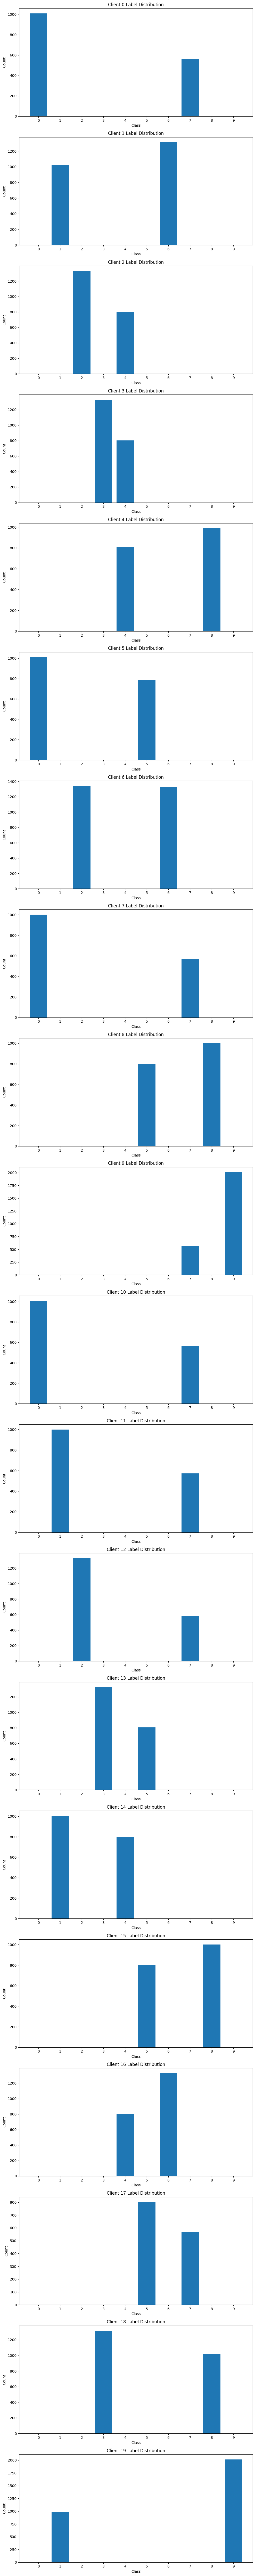

<Figure size 640x480 with 0 Axes>

In [111]:
# Plot label distributions for each client
fig, axs = plt.subplots(NUM_PARTITIONS, 1, figsize=(10, 100))
for i, (ax, distribution) in enumerate(zip(axs, label_distributions)):
    # Explicitly set x-axis ticks and labels
    ax.bar(distribution.keys(), distribution.values())
    ax.set_xticks(range(10))  # Set ticks for 0 to 9
    ax.set_xticklabels(range(10))  # Set labels for 0 to 9
    ax.set_title(f"Client {i} Label Distribution")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

In [112]:
def load_datasets(partition_id: int):
    return load_non_iid_datasets(partition_id)

## Step 3: Define the neural network using PyTorch


In [114]:
import time


transfer_model_size_history = []
transfer_model_time_duration_history = []


# Define the neural network model
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Function to train the model
def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

# Function to evaluate the model
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Function to get model parameters
def get_parameters(net) -> List[np.ndarray]:
    start_time = time.time()
    params = [val.cpu().numpy() for _, val in net.state_dict().items()]
    end_time = time.time()
    
    # Calculate model size in bytes
    model_size = sum(param.nbytes for param in params)
    transfer_model_size_history.append(model_size)
    
    # Calculate time duration
    duration = end_time - start_time
    transfer_model_time_duration_history.append(duration)

    print("Get Model Size: ", model_size , " Duration: " , duration)
    
    return params

# Function to set model parameters
def set_parameters(net, parameters: List[np.ndarray]):
    start_time = time.time()
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)
    end_time = time.time()
    
    # Calculate model size in bytes
    model_size = sum(param.nbytes for param in parameters)
    transfer_model_size_history.append(model_size)
    
    # Calculate time duration
    duration = end_time - start_time
    transfer_model_time_duration_history.append(duration)

    
    print("Set Model Size: ", model_size , " Duration: " , duration)

In [115]:
# Define the FlowerClient class
class FlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs= Local_Epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)

    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]

    trainloader, valloader = load_datasets(partition_id)
    return FlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [116]:
# Lists to store the results
loss_history = []
accuracy_history = []

# The `evaluate` function will be called by Flower after every round of training in Server
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = Net().to(DEVICE)
    testloader = get_testloader()
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    
    # Store the results
    loss_history.append(loss)
    accuracy_history.append(accuracy)
    return loss, {"accuracy": accuracy}

# Create an instance of the model and get the parameters
params = get_parameters(Net())

def server_fn(context: Context) -> ServerAppComponents:
    # Create the FedAvg strategy
    strategy = FedAvg(
        fraction_fit=NUM_SELECTED_CLIENTS/NUM_PARTITIONS,
        fraction_evaluate=1/NUM_PARTITIONS,
        min_fit_clients=10,
        min_evaluate_clients=1,
        min_available_clients=NUM_PARTITIONS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=evaluate,
    )
    # Configure the server for 150 rounds of training
    config = ServerConfig(num_rounds=FL_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)

Get Model Size:  248024  Duration:  0.005856037139892578


In [117]:
# Create ServerApp
server = ServerApp(server_fn=server_fn)

In [118]:
# Specify the resources each of your clients need
# Allocate all 8 CPU cores to each client
backend_config = {"client_resources": {"num_cpus": 8}}
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_gpus": 1, "num_cpus": 6}}

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,  # Number of clients
    backend_config=backend_config,
    verbose_logging=True,
)

DEBUG 2025-03-18 16:23:33,112:     Asyncio event loop already running.
DEBUG 2025-03-18 16:23:33,120:     Logger propagate set to False
DEBUG 2025-03-18 16:23:33,122:     Pre-registering run with id 12885602794347419252
DEBUG 2025-03-18 16:23:33,124:     Using InMemoryState
DEBUG 2025-03-18 16:23:33,124:     Using InMemoryState
INFO 2025-03-18 16:23:33,130:      Starting Flower ServerApp, config: num_rounds=100, no round_timeout
INFO 2025-03-18 16:23:33,131:      
DEBUG 2025-03-18 16:23:33,131:     Using InMemoryState
INFO 2025-03-18 16:23:33,132:      [INIT]
DEBUG 2025-03-18 16:23:33,133:     Registered 20 nodes
INFO 2025-03-18 16:23:33,133:      Using initial global parameters provided by strategy
DEBUG 2025-03-18 16:23:33,134:     Supported backends: ['ray']
INFO 2025-03-18 16:23:33,135:      Starting evaluation of initial global parameters
DEBUG 2025-03-18 16:23:33,135:     Initialising: RayBackend
DEBUG 2025-03-18 16:23:33,143:     Backend config: {'client_resources': {'num_cpus':

Set Model Size:  248024  Duration:  0.015444040298461914
Server-side evaluation loss 0.07210674197673797 / accuracy 0.1


INFO 2025-03-18 16:23:34,932:      initial parameters (loss, other metrics): 0.07210674197673797, {'accuracy': 0.1}
INFO 2025-03-18 16:23:34,933:      
INFO 2025-03-18 16:23:34,933:      [ROUND 1]
INFO 2025-03-18 16:23:36,137:      configure_fit: strategy sampled 10 clients (out of 20)
2025-03-18 16:23:36,139	INFO worker.py:1771 -- Started a local Ray instance.
DEBUG 2025-03-18 16:23:36,710:     Constructed ActorPool with: 1 actors
DEBUG 2025-03-18 16:23:36,711:     Using InMemoryState


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004038810729980469
(ClientAppActor pid=30753) Epoch 1: train loss 0.030469292774796486, accuracy 0.6202290076335878
(ClientAppActor pid=30753) Epoch 2: train loss 0.014012213796377182, accuracy 0.8027989821882952
(ClientAppActor pid=30753) Epoch 3: train loss 0.013559258542954922, accuracy 0.8212468193384224
(ClientAppActor pid=30753) Epoch 4: train loss 0.011462104506790638, accuracy 0.8384223918575063
(ClientAppActor pid=30753) Epoch 5: train loss 0.011249293573200703, accuracy 0.8396946564885496
(ClientAppActor pid=30753) Epoch 6: train loss 0.01066482812166214, accuracy 0.8568702290076335
(ClientAppActor pid=30753) Epoch 7: train loss 0.0103968046605587, accuracy 0.8664122137404581
(ClientAppActor pid=30753) Epoch 8: train loss 0.009549521841108799, accuracy 0.8740458015267175
(ClientAppActor pid=30753) Epoch 9: train loss 0.008858277462422848, accuracy 0.88740458

INFO 2025-03-18 16:24:50,050:      aggregate_fit: received 10 results and 0 failures
WARNING 2025-03-18 16:24:50,057:   No fit_metrics_aggregation_fn provided


Set Model Size:  248024  Duration:  0.0005450248718261719
Server-side evaluation loss 0.07231730539798736 / accuracy 0.172


INFO 2025-03-18 16:24:51,692:      fit progress: (1, 0.07231730539798736, {'accuracy': 0.172}, 76.76014395900711)
INFO 2025-03-18 16:24:51,692:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 2] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004458427429199219


INFO 2025-03-18 16:24:52,114:      aggregate_evaluate: received 1 results and 0 failures
WARNING 2025-03-18 16:24:52,115:   No evaluate_metrics_aggregation_fn provided
INFO 2025-03-18 16:24:52,115:      
INFO 2025-03-18 16:24:52,116:      [ROUND 2]
INFO 2025-03-18 16:24:52,116:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003478527069091797
(ClientAppActor pid=30753) Epoch 1: train loss 0.017819877713918686, accuracy 0.7824427480916031
(ClientAppActor pid=30753) Epoch 2: train loss 0.011717922054231167, accuracy 0.839058524173028
(ClientAppActor pid=30753) Epoch 3: train loss 0.010637839324772358, accuracy 0.8581424936386769
(ClientAppActor pid=30753) Epoch 4: train loss 0.00892303604632616, accuracy 0.8829516539440203
(ClientAppActor pid=30753) Epoch 5: train loss 0.00820185337215662, accuracy 0.8899491094147582
(ClientAppActor pid=30753) Epoch 6: train loss 0.007361774332821369, accuracy 0.9052162849872774
(ClientAppActor pid=30753) Epoch 7: train loss 0.0071043092757463455, accuracy 0.9141221374045801
(ClientAppActor pid=30753) Epoch 8: train loss 0.0063310409896075726, accuracy 0.926208651399491
(ClientAppActor pid=30753) Epoch 9: train loss 0.007046690210700035, accuracy 0.9153944

INFO 2025-03-18 16:26:11,253:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00030422210693359375
Server-side evaluation loss 0.07511653105020523 / accuracy 0.1707


INFO 2025-03-18 16:26:12,855:      fit progress: (2, 0.07511653105020523, {'accuracy': 0.1707}, 157.9255173749989)
INFO 2025-03-18 16:26:12,856:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 8] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003840923309326172


INFO 2025-03-18 16:26:13,173:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:26:13,173:      
INFO 2025-03-18 16:26:13,174:      [ROUND 3]
INFO 2025-03-18 16:26:13,174:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.000415802001953125
(ClientAppActor pid=30753) Epoch 1: train loss 0.014927439391613007, accuracy 0.823791348600509
(ClientAppActor pid=30753) Epoch 2: train loss 0.008285749703645706, accuracy 0.8861323155216285
(ClientAppActor pid=30753) Epoch 3: train loss 0.007277220021933317, accuracy 0.916030534351145
(ClientAppActor pid=30753) Epoch 4: train loss 0.006981440354138613, accuracy 0.9122137404580153
(ClientAppActor pid=30753) Epoch 5: train loss 0.006404460407793522, accuracy 0.9223918575063613
(ClientAppActor pid=30753) Epoch 6: train loss 0.006271406076848507, accuracy 0.9249363867684478
(ClientAppActor pid=30753) Epoch 7: train loss 0.005339600145816803, accuracy 0.933206106870229
(ClientAppActor pid=30753) Epoch 8: train loss 0.004825403913855553, accuracy 0.9478371501272265
(ClientAppActor pid=30753) Epoch 9: train loss 0.004397384822368622, accuracy 0.947837150

INFO 2025-03-18 16:27:25,936:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00037598609924316406
(ClientAppActor pid=30753) Epoch 10: train loss 0.0030536928679794073, accuracy 0.9626929674099486
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.0001010894775390625
Server-side evaluation loss 0.07269007533788681 / accuracy 0.1696


INFO 2025-03-18 16:27:27,667:      fit progress: (3, 0.07269007533788681, {'accuracy': 0.1696}, 232.73850608400244)
INFO 2025-03-18 16:27:27,667:      configure_evaluate: strategy sampled 1 clients (out of 20)
INFO 2025-03-18 16:27:27,982:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:27:27,983:      
INFO 2025-03-18 16:27:27,983:      [ROUND 4]
INFO 2025-03-18 16:27:27,983:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 11] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004458427429199219
(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00033593177795410156
(ClientAppActor pid=30753) Epoch 1: train loss 0.008821592666208744, accuracy 0.9013994910941476
(ClientAppActor pid=30753) Epoch 2: train loss 0.006437984295189381, accuracy 0.9249363867684478
(ClientAppActor pid=30753) Epoch 3: train loss 0.0056082415394485, accuracy 0.9338422391857506
(ClientAppActor pid=30753) Epoch 4: train loss 0.004960169084370136, accuracy 0.9395674300254453
(ClientAppActor pid=30753) Epoch 5: train loss 0.005030605476349592, accuracy 0.938295165394402
(ClientAppActor pid=30753) Epoch 6: train loss 0.004850428085774183, accuracy 0.9414758269720102
(ClientAppActor pid=30753) Epoch 7: train loss 0.005747057497501373, accuracy 0.9293893129770993
(ClientAppActor pid=30753) Epoch 8: tra

INFO 2025-03-18 16:28:34,384:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00033402442932128906
Server-side evaluation loss 0.07812442628145218 / accuracy 0.1889


INFO 2025-03-18 16:28:36,338:      fit progress: (4, 0.07812442628145218, {'accuracy': 0.1889}, 301.41053562500747)
INFO 2025-03-18 16:28:36,338:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 9] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002758502960205078


INFO 2025-03-18 16:28:36,762:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:28:36,762:      
INFO 2025-03-18 16:28:36,763:      [ROUND 5]
INFO 2025-03-18 16:28:36,763:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00022101402282714844
(ClientAppActor pid=30753) Epoch 1: train loss 0.00788148958235979, accuracy 0.9115776081424937
(ClientAppActor pid=30753) Epoch 2: train loss 0.005873668473213911, accuracy 0.926208651399491
(ClientAppActor pid=30753) Epoch 3: train loss 0.004712298512458801, accuracy 0.9421119592875318
(ClientAppActor pid=30753) Epoch 4: train loss 0.004378917161375284, accuracy 0.9497455470737913
(ClientAppActor pid=30753) Epoch 5: train loss 0.0038279243744909763, accuracy 0.9516539440203562
(ClientAppActor pid=30753) Epoch 6: train loss 0.003575071692466736, accuracy 0.9611959287531806
(ClientAppActor pid=30753) Epoch 7: train loss 0.0026576572563499212, accuracy 0.9707379134860051
(ClientAppActor pid=30753) Epoch 8: train loss 0.0027407307643443346, accuracy 0.9681933842239185
(ClientAppActor pid=30753) Epoch 9: train loss 0.0022827049251645803, accuracy 0.97

INFO 2025-03-18 16:29:53,296:      aggregate_fit: received 10 results and 0 failures



Set Model Size:  248024  Duration:  0.0011827945709228516
Server-side evaluation loss 0.06995751879215241 / accuracy 0.2316


INFO 2025-03-18 16:29:54,957:      fit progress: (5, 0.06995751879215241, {'accuracy': 0.2316}, 380.03142895900237)
INFO 2025-03-18 16:29:54,957:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 7] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004467964172363281


INFO 2025-03-18 16:29:55,370:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:29:55,370:      
INFO 2025-03-18 16:29:55,370:      [ROUND 6]
INFO 2025-03-18 16:29:55,371:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 2] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002391338348388672
(ClientAppActor pid=30753) Epoch 1: train loss 0.021297579631209373, accuracy 0.6680731364275668
(ClientAppActor pid=30753) Epoch 2: train loss 0.016532052308321, accuracy 0.73370839193624
(ClientAppActor pid=30753) Epoch 3: train loss 0.014942382462322712, accuracy 0.773089545241444
(ClientAppActor pid=30753) Epoch 4: train loss 0.014273470267653465, accuracy 0.7819971870604782
(ClientAppActor pid=30753) Epoch 5: train loss 0.013348059728741646, accuracy 0.8087201125175809
(ClientAppActor pid=30753) Epoch 6: train loss 0.011596702970564365, accuracy 0.8410689170182841
(ClientAppActor pid=30753) Epoch 7: train loss 0.011362145654857159, accuracy 0.8330989217065167
(ClientAppActor pid=30753) Epoch 8: train loss 0.009290330111980438, accuracy 0.869198312236287
(ClientAppActor pid=30753) Epoch 9: train loss 0.00784740038216114, accuracy 0.8949835911861

INFO 2025-03-18 16:31:09,223:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0003268718719482422
Server-side evaluation loss 0.06484790740013123 / accuracy 0.2737


INFO 2025-03-18 16:31:10,962:      fit progress: (6, 0.06484790740013123, {'accuracy': 0.2737}, 456.0376706250099)
INFO 2025-03-18 16:31:10,962:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 12] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00036215782165527344


INFO 2025-03-18 16:31:11,386:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:31:11,387:      
INFO 2025-03-18 16:31:11,387:      [ROUND 7]
INFO 2025-03-18 16:31:11,387:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002460479736328125
(ClientAppActor pid=30753) Epoch 1: train loss 0.009058566763997078, accuracy 0.9090330788804071
(ClientAppActor pid=30753) Epoch 2: train loss 0.004689544904977083, accuracy 0.943384223918575
(ClientAppActor pid=30753) Epoch 3: train loss 0.003830955596640706, accuracy 0.9567430025445293
(ClientAppActor pid=30753) Epoch 4: train loss 0.003241488942876458, accuracy 0.9618320610687023
(ClientAppActor pid=30753) Epoch 5: train loss 0.0024919307325035334, accuracy 0.9681933842239185
(ClientAppActor pid=30753) Epoch 6: train loss 0.0016320988070219755, accuracy 0.9821882951653944
(ClientAppActor pid=30753) Epoch 7: train loss 0.0018031226936727762, accuracy 0.9796437659033079
(ClientAppActor pid=30753) Epoch 8: train loss 0.0008306016679853201, accuracy 0.9942748091603053
(ClientAppActor pid=30753) Epoch 9: train loss 0.0004765846242662519, accuracy 0.9

INFO 2025-03-18 16:32:23,192:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0005328655242919922
(ClientAppActor pid=30753) Epoch 10: train loss 0.002027316950261593, accuracy 0.977
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.00011491775512695312
Server-side evaluation loss 0.07095409753322601 / accuracy 0.2128


INFO 2025-03-18 16:32:24,871:      fit progress: (7, 0.07095409753322601, {'accuracy': 0.2128}, 529.9483416670118)
INFO 2025-03-18 16:32:24,871:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 15] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004017353057861328


INFO 2025-03-18 16:32:25,189:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:32:25,189:      
INFO 2025-03-18 16:32:25,190:      [ROUND 8]
INFO 2025-03-18 16:32:25,190:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.000354766845703125
(ClientAppActor pid=30753) Epoch 1: train loss 0.009745595045387745, accuracy 0.896699528504072
(ClientAppActor pid=30753) Epoch 2: train loss 0.004358827136456966, accuracy 0.9468495499357051
(ClientAppActor pid=30753) Epoch 3: train loss 0.0030800504609942436, accuracy 0.9661380197171024
(ClientAppActor pid=30753) Epoch 4: train loss 0.0023804856464266777, accuracy 0.9759965709387055
(ClientAppActor pid=30753) Epoch 5: train loss 0.001914660562761128, accuracy 0.9747106729532791
(ClientAppActor pid=30753) Epoch 6: train loss 0.0014114425284788013, accuracy 0.9841405915130733
(ClientAppActor pid=30753) Epoch 7: train loss 0.0010509984567761421, accuracy 0.9897128161165881
(ClientAppActor pid=30753) Epoch 8: train loss 0.0005235309363342822, accuracy 0.9965709387055294
(ClientAppActor pid=30753) Epoch 9: train loss 0.0004811613471247256, accuracy 0.9

INFO 2025-03-18 16:33:45,959:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0003352165222167969
Server-side evaluation loss 0.06008537180423736 / accuracy 0.3232


INFO 2025-03-18 16:33:47,876:      fit progress: (8, 0.06008537180423736, {'accuracy': 0.3232}, 612.9545734999992)
INFO 2025-03-18 16:33:47,876:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 16] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004248619079589844


INFO 2025-03-18 16:33:48,317:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:33:48,318:      
INFO 2025-03-18 16:33:48,318:      [ROUND 9]
INFO 2025-03-18 16:33:48,318:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00036787986755371094
(ClientAppActor pid=30753) Epoch 1: train loss 0.006085595116019249, accuracy 0.9327046720960137
(ClientAppActor pid=30753) Epoch 2: train loss 0.0031491839326918125, accuracy 0.9631375910844406
(ClientAppActor pid=30753) Epoch 3: train loss 0.00218101660721004, accuracy 0.9738534076296613
(ClientAppActor pid=30753) Epoch 4: train loss 0.0017428318969905376, accuracy 0.979854264894985
(ClientAppActor pid=30753) Epoch 5: train loss 0.0009194260346703231, accuracy 0.992284612087441
(ClientAppActor pid=30753) Epoch 6: train loss 0.0004605170979630202, accuracy 0.997428204029147
(ClientAppActor pid=30753) Epoch 7: train loss 0.00030894624069333076, accuracy 0.9987141020145736
(ClientAppActor pid=30753) Epoch 8: train loss 0.0004920701612718403, accuracy 0.9952850407201028
(ClientAppActor pid=30753) Epoch 9: train loss 0.00012678673374466598, accuracy 0

INFO 2025-03-18 16:35:04,677:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00033092498779296875
(ClientAppActor pid=30753) Epoch 10: train loss 0.00011706257646437734, accuracy 1.0
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.00012922286987304688
Server-side evaluation loss 0.06874745118618011 / accuracy 0.3183


INFO 2025-03-18 16:35:06,470:      fit progress: (9, 0.06874745118618011, {'accuracy': 0.3183}, 691.5502871670033)
INFO 2025-03-18 16:35:06,470:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 11] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003750324249267578


INFO 2025-03-18 16:35:06,788:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:35:06,788:      
INFO 2025-03-18 16:35:06,788:      [ROUND 10]
INFO 2025-03-18 16:35:06,789:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00024008750915527344
(ClientAppActor pid=30753) Epoch 1: train loss 0.008895425125956535, accuracy 0.905852417302799
(ClientAppActor pid=30753) Epoch 2: train loss 0.0033757041674107313, accuracy 0.9567430025445293
(ClientAppActor pid=30753) Epoch 3: train loss 0.002245330484583974, accuracy 0.9783715012722646
(ClientAppActor pid=30753) Epoch 4: train loss 0.001191341201774776, accuracy 0.9891857506361323
(ClientAppActor pid=30753) Epoch 5: train loss 0.0010549217695370317, accuracy 0.9891857506361323
(ClientAppActor pid=30753) Epoch 6: train loss 0.0006534301210194826, accuracy 0.9949109414758269
(ClientAppActor pid=30753) Epoch 7: train loss 0.0004286549228709191, accuracy 0.9987277353689568
(ClientAppActor pid=30753) Epoch 8: train loss 0.0006879533757455647, accuracy 0.9923664122137404
(ClientAppActor pid=30753) Epoch 9: train loss 0.00023526704171672463, accuracy 

INFO 2025-03-18 16:36:18,925:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  (ClientAppActor pid=30753)248024 Epoch 10: train loss 5.5432075896533206e-05, accuracy 1.0 
 Duration: (ClientAppActor pid=30753)  Get Model Size:  248024  Duration:  5.412101745605469e-050.00036215782165527344

Server-side evaluation loss 0.08394670915603637 / accuracy 0.2812


INFO 2025-03-18 16:36:20,639:      fit progress: (10, 0.08394670915603637, {'accuracy': 0.2812}, 765.7206256250065)
INFO 2025-03-18 16:36:20,639:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 5] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003597736358642578


INFO 2025-03-18 16:36:21,060:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:36:21,061:      
INFO 2025-03-18 16:36:21,061:      [ROUND 11]
INFO 2025-03-18 16:36:21,061:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 4] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00030994415283203125
(ClientAppActor pid=30753) Epoch 1: train loss 0.010048903524875641, accuracy 0.8822222222222222
(ClientAppActor pid=30753) Epoch 2: train loss 0.004623050335794687, accuracy 0.9433333333333334
(ClientAppActor pid=30753) Epoch 3: train loss 0.004391639493405819, accuracy 0.9422222222222222
(ClientAppActor pid=30753) Epoch 4: train loss 0.0025039438623934984, accuracy 0.9705555555555555
(ClientAppActor pid=30753) Epoch 5: train loss 0.001659114845097065, accuracy 0.9844444444444445
(ClientAppActor pid=30753) Epoch 6: train loss 0.0010417266748845577, accuracy 0.9905555555555555
(ClientAppActor pid=30753) Epoch 7: train loss 0.000719589414075017, accuracy 0.9944444444444445
(ClientAppActor pid=30753) Epoch 8: train loss 0.000380907382350415, accuracy 0.9994444444444445
(ClientAppActor pid=30753) Epoch 9: train loss 0.00017997596296481788, accuracy 0.

INFO 2025-03-18 16:37:36,925:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00031685829162597656
Server-side evaluation loss 0.08094029009342193 / accuracy 0.2918


INFO 2025-03-18 16:37:38,630:      fit progress: (11, 0.08094029009342193, {'accuracy': 0.2918}, 843.7131437500066)
INFO 2025-03-18 16:37:38,630:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 6] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003502368927001953


INFO 2025-03-18 16:37:39,051:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:37:39,052:      
INFO 2025-03-18 16:37:39,052:      [ROUND 12]
INFO 2025-03-18 16:37:39,052:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 3] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00037789344787597656
(ClientAppActor pid=30753) Epoch 1: train loss 0.018987644463777542, accuracy 0.7763713080168776
(ClientAppActor pid=30753) Epoch 2: train loss 0.009787908755242825, accuracy 0.8649789029535865
(ClientAppActor pid=30753) Epoch 3: train loss 0.007732047233730555, accuracy 0.8987341772151899
(ClientAppActor pid=30753) Epoch 4: train loss 0.006199727300554514, accuracy 0.9231129864041256
(ClientAppActor pid=30753) Epoch 5: train loss 0.005169882904738188, accuracy 0.9399906235349273
(ClientAppActor pid=30753) Epoch 6: train loss 0.0037648624274879694, accuracy 0.9582747304266291
(ClientAppActor pid=30753) Epoch 7: train loss 0.002396873664110899, accuracy 0.9798406000937646
(ClientAppActor pid=30753) Epoch 8: train loss 0.002083804691210389, accuracy 0.976558837318331
(ClientAppActor pid=30753) Epoch 9: train loss 0.0013845486100763083, accuracy 0.986

INFO 2025-03-18 16:38:52,916:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0002999305725097656
(ClientAppActor pid=30753) Epoch 10: train loss 0.000369825167581439, accuracy 0.99906191369606
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  5.316734313964844e-05
Server-side evaluation loss 0.08457465575933457 / accuracy 0.2668


INFO 2025-03-18 16:38:54,675:      fit progress: (12, 0.08457465575933457, {'accuracy': 0.2668}, 919.7597029169992)
INFO 2025-03-18 16:38:54,675:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 15] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00038814544677734375


INFO 2025-03-18 16:38:55,099:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:38:55,100:      
INFO 2025-03-18 16:38:55,100:      [ROUND 13]
INFO 2025-03-18 16:38:55,100:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00022721290588378906
(ClientAppActor pid=30753) Epoch 1: train loss 0.006724225822836161, accuracy 0.9185597942563223
(ClientAppActor pid=30753) Epoch 2: train loss 0.0021865624003112316, accuracy 0.9751393056150879
(ClientAppActor pid=30753) Epoch 3: train loss 0.0012352763442322612, accuracy 0.9884269181311616
(ClientAppActor pid=30753) Epoch 4: train loss 0.0011468693846836686, accuracy 0.9879982854693528
(ClientAppActor pid=30753) Epoch 5: train loss 0.00031462550396099687, accuracy 0.9982854693527646
(ClientAppActor pid=30753) Epoch 6: train loss 0.00016595199122093618, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 7.196137448772788e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 3.723579357028939e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 2.500367736502085e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: 

INFO 2025-03-18 16:40:16,418:      aggregate_fit: received 10 results and 0 failures


Set Model Size: (ClientAppActor pid=30753)  Epoch 10: train loss 3.8554873754037544e-05, accuracy 1.0248024
 (ClientAppActor pid=30753) Duration:  Get Model Size:  248024  Duration:  6.318092346191406e-05 
0.00030994415283203125
Server-side evaluation loss 0.07662006402015686 / accuracy 0.3299


INFO 2025-03-18 16:40:18,241:      fit progress: (13, 0.07662006402015686, {'accuracy': 0.3299}, 1003.3271538750123)
INFO 2025-03-18 16:40:18,241:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 16] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00028705596923828125


INFO 2025-03-18 16:40:18,559:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:40:18,559:      
INFO 2025-03-18 16:40:18,559:      [ROUND 14]
INFO 2025-03-18 16:40:18,560:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 3] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00031113624572753906
(ClientAppActor pid=30753) Epoch 1: train loss 0.017099162563681602, accuracy 0.7880918893577121
(ClientAppActor pid=30753) Epoch 2: train loss 0.008308973163366318, accuracy 0.8912330051570558
(ClientAppActor pid=30753) Epoch 3: train loss 0.0065070828422904015, accuracy 0.9156118143459916
(ClientAppActor pid=30753) Epoch 4: train loss 0.004514679778367281, accuracy 0.9474917955930614
(ClientAppActor pid=30753) Epoch 5: train loss 0.0033281573560088873, accuracy 0.9662447257383966
(ClientAppActor pid=30753) Epoch 6: train loss 0.0022264267317950726, accuracy 0.976558837318331
(ClientAppActor pid=30753) Epoch 7: train loss 0.0013964796671643853, accuracy 0.9882794186591655
(ClientAppActor pid=30753) Epoch 8: train loss 0.0010130421724170446, accuracy 0.992498827941866
(ClientAppActor pid=30753) Epoch 9: train loss 0.0007558751967735589, accuracy 0.

INFO 2025-03-18 16:41:29,476:      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=30753)Set Model Size:  Epoch 10: train loss 0.00016907075769267976, accuracy 1.0 
248024(ClientAppActor pid=30753)  Duration:  Get Model Size:  248024  Duration:  6.29425048828125e-05 
0.0050868988037109375
Server-side evaluation loss 0.08747868719100953 / accuracy 0.3004


INFO 2025-03-18 16:41:31,267:      fit progress: (14, 0.08747868719100953, {'accuracy': 0.3004}, 1076.2986881670076)
INFO 2025-03-18 16:41:31,267:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 18] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004050731658935547


INFO 2025-03-18 16:41:31,688:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:41:31,688:      
INFO 2025-03-18 16:41:31,688:      [ROUND 15]
INFO 2025-03-18 16:41:31,689:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003612041473388672
(ClientAppActor pid=30753) Epoch 1: train loss 0.005882675759494305, accuracy 0.9309901414487785
(ClientAppActor pid=30753) Epoch 2: train loss 0.0014153876109048724, accuracy 0.9841405915130733
(ClientAppActor pid=30753) Epoch 3: train loss 0.0006875656545162201, accuracy 0.9939991427346764
(ClientAppActor pid=30753) Epoch 4: train loss 0.0006046705530025065, accuracy 0.9935705100728676
(ClientAppActor pid=30753) Epoch 5: train loss 0.0004118234501220286, accuracy 0.9952850407201028
(ClientAppActor pid=30753) Epoch 6: train loss 0.00018112044199369848, accuracy 0.9995713673381912
(ClientAppActor pid=30753) Epoch 7: train loss 5.095322194392793e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 0.00011617180280154571, accuracy 0.9995713673381912
(ClientAppActor pid=30753) Epoch 9: train loss 3.451522934483364e-05, accuracy 1.0
(ClientA

INFO 2025-03-18 16:42:44,764:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0003418922424316406
Server-side evaluation loss 0.08704529733657837 / accuracy 0.3235


INFO 2025-03-18 16:42:46,561:      fit progress: (15, 0.08704529733657837, {'accuracy': 0.3235}, 1151.5935905420047)
INFO 2025-03-18 16:42:46,562:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 16] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003399848937988281


INFO 2025-03-18 16:42:46,982:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:42:46,982:      
INFO 2025-03-18 16:42:46,983:      [ROUND 16]
INFO 2025-03-18 16:42:46,984:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00037407875061035156
(ClientAppActor pid=30753) Epoch 1: train loss 0.012823961675167084, accuracy 0.8893129770992366
(ClientAppActor pid=30753) Epoch 2: train loss 0.003108880016952753, accuracy 0.960559796437659
(ClientAppActor pid=30753) Epoch 3: train loss 0.0015716379275545478, accuracy 0.9821882951653944
(ClientAppActor pid=30753) Epoch 4: train loss 0.0006918212748132646, accuracy 0.9955470737913485
(ClientAppActor pid=30753) Epoch 5: train loss 0.0003384079609531909, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 0.00015897817502263933, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 8.024388807825744e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 5.59935906494502e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 4.2055031372001395e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 3.29034

INFO 2025-03-18 16:44:11,786:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0006642341613769531
Server-side evaluation loss 0.08749067871570587 / accuracy 0.3151


INFO 2025-03-18 16:44:13,551:      fit progress: (16, 0.08749067871570587, {'accuracy': 0.3151}, 1238.5847267920035)
INFO 2025-03-18 16:44:13,552:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 19] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00043511390686035156


INFO 2025-03-18 16:44:14,072:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:44:14,073:      
INFO 2025-03-18 16:44:14,073:      [ROUND 17]
INFO 2025-03-18 16:44:14,073:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00025200843811035156
(ClientAppActor pid=30753) Epoch 1: train loss 0.01028913352638483, accuracy 0.9001272264631043
(ClientAppActor pid=30753) Epoch 2: train loss 0.0025996810290962458, accuracy 0.9681933842239185
(ClientAppActor pid=30753) Epoch 3: train loss 0.0012124887434765697, accuracy 0.9885496183206107
(ClientAppActor pid=30753) Epoch 4: train loss 0.0007432692218571901, accuracy 0.9936386768447837
(ClientAppActor pid=30753) Epoch 5: train loss 0.00021522925817407668, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 9.438645793125033e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 5.879023592569865e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 3.78574404749088e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 2.750167368503753e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 2.12812

INFO 2025-03-18 16:45:32,775:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0008127689361572266
Server-side evaluation loss 0.09986776777505875 / accuracy 0.2944


INFO 2025-03-18 16:45:34,610:      fit progress: (17, 0.09986776777505875, {'accuracy': 0.2944}, 1319.644263042006)
INFO 2025-03-18 16:45:34,610:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 6] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00040078163146972656


INFO 2025-03-18 16:45:35,138:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:45:35,139:      
INFO 2025-03-18 16:45:35,139:      [ROUND 18]
INFO 2025-03-18 16:45:35,140:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00028204917907714844
(ClientAppActor pid=30753) Epoch 1: train loss 0.009827486239373684, accuracy 0.9007633587786259
(ClientAppActor pid=30753) Epoch 2: train loss 0.0026608442422002554, accuracy 0.9688295165394402
(ClientAppActor pid=30753) Epoch 3: train loss 0.0009873680537566543, accuracy 0.9904580152671756
(ClientAppActor pid=30753) Epoch 4: train loss 0.0006165950908325613, accuracy 0.9968193384223919
(ClientAppActor pid=30753) Epoch 5: train loss 0.00019906072702724487, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 9.125341603066772e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 5.233778938418254e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 3.696842395584099e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 2.840365414158441e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 2.307

INFO 2025-03-18 16:47:01,479:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration: (ClientAppActor pid=30753)  Epoch 10: train loss 0.0021745129488408566, accuracy 0.9770.0003399848937988281

(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.0001239776611328125
Server-side evaluation loss 0.08987191104888916 / accuracy 0.2828


INFO 2025-03-18 16:47:03,445:      fit progress: (18, 0.08987191104888916, {'accuracy': 0.2828}, 1408.4807352500065)
INFO 2025-03-18 16:47:03,446:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 17] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004551410675048828


INFO 2025-03-18 16:47:03,764:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:47:03,765:      
INFO 2025-03-18 16:47:03,765:      [ROUND 19]
INFO 2025-03-18 16:47:03,765:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002682209014892578
(ClientAppActor pid=30753) Epoch 1: train loss 0.01005083043128252, accuracy 0.9128498727735369
(ClientAppActor pid=30753) Epoch 2: train loss 0.001998771447688341, accuracy 0.9783715012722646
(ClientAppActor pid=30753) Epoch 3: train loss 0.000854014593642205, accuracy 0.9910941475826972
(ClientAppActor pid=30753) Epoch 4: train loss 0.0002765447716228664, accuracy 0.9993638676844784
(ClientAppActor pid=30753) Epoch 5: train loss 0.00010908474359894171, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 6.021709486958571e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 4.175105277681723e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 2.930874688900076e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 2.205322562076617e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 1.8479528

INFO 2025-03-18 16:48:25,921:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0003421306610107422
Server-side evaluation loss 0.08787506915330887 / accuracy 0.3174


INFO 2025-03-18 16:48:27,692:      fit progress: (19, 0.08787506915330887, {'accuracy': 0.3174}, 1492.7276592499984)
INFO 2025-03-18 16:48:27,692:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 18] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00043702125549316406


INFO 2025-03-18 16:48:28,110:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:48:28,110:      
INFO 2025-03-18 16:48:28,110:      [ROUND 20]
INFO 2025-03-18 16:48:28,111:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002307891845703125
(ClientAppActor pid=30753) Epoch 1: train loss 0.006618065759539604, accuracy 0.9271324474924989
(ClientAppActor pid=30753) Epoch 2: train loss 0.0012301323004066944, accuracy 0.9845692241748821
(ClientAppActor pid=30753) Epoch 3: train loss 0.0002923776919487864, accuracy 0.9987141020145736
(ClientAppActor pid=30753) Epoch 4: train loss 0.000174202723428607, accuracy 0.9991427346763824
(ClientAppActor pid=30753) Epoch 5: train loss 0.0003476277634035796, accuracy 0.9957136733819117
(ClientAppActor pid=30753) Epoch 6: train loss 0.0016036411980167031, accuracy 0.9819974282040291
(ClientAppActor pid=30753) Epoch 7: train loss 0.001003288198262453, accuracy 0.9867123874839263
(ClientAppActor pid=30753) Epoch 8: train loss 0.00027899391716346145, accuracy 0.9982854693527646
(ClientAppActor pid=30753) Epoch 9: train loss 0.0001338973524980247, accuracy 

INFO 2025-03-18 16:49:53,949:      aggregate_fit: received 10 results and 0 failures


 Epoch 10: train loss 1.1245787391089834e-05, accuracy 1.0
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.0001220703125
Set Model Size:  248024  Duration:  0.002003908157348633
Server-side evaluation loss 0.10185369611978531 / accuracy 0.3085


INFO 2025-03-18 16:49:55,751:      fit progress: (20, 0.10185369611978531, {'accuracy': 0.3085}, 1580.7883660840016)
INFO 2025-03-18 16:49:55,752:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 6] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003180503845214844


INFO 2025-03-18 16:49:56,168:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:49:56,168:      
INFO 2025-03-18 16:49:56,168:      [ROUND 21]
INFO 2025-03-18 16:49:56,169:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003151893615722656
(ClientAppActor pid=30753) Epoch 1: train loss 0.013063971884548664, accuracy 0.888676844783715
(ClientAppActor pid=30753) Epoch 2: train loss 0.0028019549790769815, accuracy 0.9669211195928753
(ClientAppActor pid=30753) Epoch 3: train loss 0.0010717492550611496, accuracy 0.9923664122137404
(ClientAppActor pid=30753) Epoch 4: train loss 0.001166993286460638, accuracy 0.9923664122137404
(ClientAppActor pid=30753) Epoch 5: train loss 0.0014143942389637232, accuracy 0.9809160305343512
(ClientAppActor pid=30753) Epoch 6: train loss 0.0002691626432351768, accuracy 0.9993638676844784
(ClientAppActor pid=30753) Epoch 7: train loss 9.494002733845264e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 5.553527080337517e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 3.6610308598028496e-05, accuracy 1.0
(ClientAppActor pid=30753)

INFO 2025-03-18 16:51:17,391:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0006611347198486328
(ClientAppActor pid=30753) Epoch 10: train loss 7.809235103195533e-05, accuracy 1.0
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.00014209747314453125
Server-side evaluation loss 0.08775538347959519 / accuracy 0.3275


INFO 2025-03-18 16:51:19,447:      fit progress: (21, 0.08775538347959519, {'accuracy': 0.3275}, 1664.4846249170077)
INFO 2025-03-18 16:51:19,447:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 7] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004506111145019531


INFO 2025-03-18 16:51:19,768:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:51:19,769:      
INFO 2025-03-18 16:51:19,769:      [ROUND 22]
INFO 2025-03-18 16:51:19,769:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 2] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00023484230041503906
(ClientAppActor pid=30753) Epoch 1: train loss 0.01660945639014244, accuracy 0.7805907172995781
(ClientAppActor pid=30753) Epoch 2: train loss 0.008195674978196621, accuracy 0.8959212376933896
(ClientAppActor pid=30753) Epoch 3: train loss 0.005273648537695408, accuracy 0.947022972339428
(ClientAppActor pid=30753) Epoch 4: train loss 0.004024134017527103, accuracy 0.9540553211439288
(ClientAppActor pid=30753) Epoch 5: train loss 0.002165049547329545, accuracy 0.9812470698546648
(ClientAppActor pid=30753) Epoch 6: train loss 0.0015015046810731292, accuracy 0.9892170651664323
(ClientAppActor pid=30753) Epoch 7: train loss 0.0007585184648633003, accuracy 0.9976558837318331
(ClientAppActor pid=30753) Epoch 8: train loss 0.0004943988751620054, accuracy 0.9981247069854665
(ClientAppActor pid=30753) Epoch 9: train loss 0.00045722202048636973, accuracy 0.9

INFO 2025-03-18 16:52:44,376:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0003409385681152344
(ClientAppActor pid=30753) Epoch 10: train loss 1.1309933142911177e-05, accuracy 1.0
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.00013303756713867188
Server-side evaluation loss 0.10230186851024628 / accuracy 0.3343


INFO 2025-03-18 16:52:46,167:      fit progress: (22, 0.10230186851024628, {'accuracy': 0.3343}, 1751.2055747920094)
INFO 2025-03-18 16:52:46,167:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 7] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002868175506591797


INFO 2025-03-18 16:52:46,488:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:52:46,488:      
INFO 2025-03-18 16:52:46,488:      [ROUND 23]
INFO 2025-03-18 16:52:46,489:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00029397010803222656
(ClientAppActor pid=30753) Epoch 1: train loss 0.010686485096812248, accuracy 0.9026717557251909
(ClientAppActor pid=30753) Epoch 2: train loss 0.0019425208447501063, accuracy 0.9758269720101781
(ClientAppActor pid=30753) Epoch 3: train loss 0.0007354667759500444, accuracy 0.9923664122137404
(ClientAppActor pid=30753) Epoch 4: train loss 0.00026637077098712325, accuracy 0.9993638676844784
(ClientAppActor pid=30753) Epoch 5: train loss 0.00010321664740331471, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 4.652463030652143e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 2.945617052318994e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 2.2607802748098038e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 1.6400945241912268e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 1.

INFO 2025-03-18 16:54:06,234:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration: (ClientAppActor pid=30753) Epoch 10: train loss 6.33316594758071e-05, accuracy 1.0 
0.00033211708068847656
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  7.987022399902344e-05
Server-side evaluation loss 0.08515697515010834 / accuracy 0.3409


INFO 2025-03-18 16:54:07,988:      fit progress: (23, 0.08515697515010834, {'accuracy': 0.3409}, 1833.0281593750115)
INFO 2025-03-18 16:54:07,989:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 11] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002949237823486328


INFO 2025-03-18 16:54:08,303:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:54:08,304:      
INFO 2025-03-18 16:54:08,304:      [ROUND 24]
INFO 2025-03-18 16:54:08,304:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003619194030761719
(ClientAppActor pid=30753) Epoch 1: train loss 0.008154995739459991, accuracy 0.9166666666666666
(ClientAppActor pid=30753) Epoch 2: train loss 0.001883377437479794, accuracy 0.9713740458015268
(ClientAppActor pid=30753) Epoch 3: train loss 0.0005685171927325428, accuracy 0.9942748091603053
(ClientAppActor pid=30753) Epoch 4: train loss 0.0002609047805890441, accuracy 0.9980916030534351
(ClientAppActor pid=30753) Epoch 5: train loss 0.0003193173324689269, accuracy 0.9974554707379135
(ClientAppActor pid=30753) Epoch 6: train loss 0.0005013796035200357, accuracy 0.9974554707379135
(ClientAppActor pid=30753) Epoch 7: train loss 0.00013809467782266438, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 3.4377750125713646e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 1.5695713955210522e-05, accuracy 1.0
(ClientAppActor pid=307

INFO 2025-03-18 16:55:31,375:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00037407875061035156
Server-side evaluation loss 0.10897362787723541 / accuracy 0.2995


INFO 2025-03-18 16:55:33,143:      fit progress: (24, 0.10897362787723541, {'accuracy': 0.2995}, 1918.183667959005)
INFO 2025-03-18 16:55:33,143:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 4] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00028586387634277344


INFO 2025-03-18 16:55:33,568:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:55:33,568:      
INFO 2025-03-18 16:55:33,568:      [ROUND 25]
INFO 2025-03-18 16:55:33,569:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002300739288330078
(ClientAppActor pid=30753) Epoch 1: train loss 0.01308536995202303, accuracy 0.8810432569974554
(ClientAppActor pid=30753) Epoch 2: train loss 0.0013673198409378529, accuracy 0.9834605597964376
(ClientAppActor pid=30753) Epoch 3: train loss 0.000463783711893484, accuracy 0.9968193384223919
(ClientAppActor pid=30753) Epoch 4: train loss 0.00014555890811607242, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 8.292723941849545e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 4.8766789404908195e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 3.33988391503226e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 2.5795594410737976e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 2.205676537414547e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 1.5944811821100302e-05

INFO 2025-03-18 16:56:50,055:      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=30753) Epoch 10: train loss 1.049363891070243e-05, accuracy 1.0
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.0001442432403564453Set Model Size: 
 248024  Duration:  0.001010894775390625
Server-side evaluation loss 0.11785474605560303 / accuracy 0.262


INFO 2025-03-18 16:56:52,043:      fit progress: (25, 0.11785474605560303, {'accuracy': 0.262}, 1997.064982959011)
INFO 2025-03-18 16:56:52,044:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 7] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00041604042053222656


INFO 2025-03-18 16:56:52,366:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:56:52,367:      
INFO 2025-03-18 16:56:52,367:      [ROUND 26]
INFO 2025-03-18 16:56:52,367:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 2] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003857612609863281
(ClientAppActor pid=30753) Epoch 1: train loss 0.012809450738132, accuracy 0.8326300984528833
(ClientAppActor pid=30753) Epoch 2: train loss 0.0049750483594834805, accuracy 0.9456165025785279
(ClientAppActor pid=30753) Epoch 3: train loss 0.0030825678259134293, accuracy 0.9704641350210971
(ClientAppActor pid=30753) Epoch 4: train loss 0.001397545333020389, accuracy 0.9934364744491326
(ClientAppActor pid=30753) Epoch 5: train loss 0.0007190285832621157, accuracy 0.9985935302390999
(ClientAppActor pid=30753) Epoch 6: train loss 0.00033180255559273064, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 0.00017066567670553923, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 0.00010273013322148472, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 7.208919123513624e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: trai

INFO 2025-03-18 16:58:19,925:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0018930435180664062
(ClientAppActor pid=30753) Epoch 10: train loss 9.859717465587892e-06, accuracy 1.0
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.0001327991485595703
Server-side evaluation loss 0.1112825006723404 / accuracy 0.3161


INFO 2025-03-18 16:58:21,817:      fit progress: (26, 0.1112825006723404, {'accuracy': 0.3161}, 2086.8254992500006)
INFO 2025-03-18 16:58:21,817:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 4] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003058910369873047


INFO 2025-03-18 16:58:22,236:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:58:22,236:      
INFO 2025-03-18 16:58:22,237:      [ROUND 27]
INFO 2025-03-18 16:58:22,237:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002429485321044922
(ClientAppActor pid=30753) Epoch 1: train loss 0.009761973284184933, accuracy 0.9096692111959288
(ClientAppActor pid=30753) Epoch 2: train loss 0.0014613833045586944, accuracy 0.9790076335877863
(ClientAppActor pid=30753) Epoch 3: train loss 0.0003532016125973314, accuracy 0.9993638676844784
(ClientAppActor pid=30753) Epoch 4: train loss 0.00010888355609495193, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 6.226143887033686e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 2.8951837521162815e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 2.0199317077640444e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.6172194591490552e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 1.2485659681260586e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 1.049461570801213

INFO 2025-03-18 16:59:47,643:      aggregate_fit: received 10 results and 0 failures


Set Model Size: (ClientAppActor pid=30753)  Epoch 10: train loss 0.0001181291663669981, accuracy 1.0248024
 (ClientAppActor pid=30753) Duration:  Get Model Size:  248024  Duration:  7.200241088867188e-05 
0.00036406517028808594
Server-side evaluation loss 0.10611923146247863 / accuracy 0.3303


INFO 2025-03-18 16:59:49,749:      fit progress: (27, 0.10611923146247863, {'accuracy': 0.3303}, 2174.7584427920083)
INFO 2025-03-18 16:59:49,750:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002739429473876953


INFO 2025-03-18 16:59:50,173:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 16:59:50,173:      
INFO 2025-03-18 16:59:50,174:      [ROUND 28]
INFO 2025-03-18 16:59:50,174:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 2] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002448558807373047
(ClientAppActor pid=30753) Epoch 1: train loss 0.014513197354972363, accuracy 0.829817158931083
(ClientAppActor pid=30753) Epoch 2: train loss 0.0049703409895300865, accuracy 0.9418659165494608
(ClientAppActor pid=30753) Epoch 3: train loss 0.0030188870150595903, accuracy 0.9676511954992968
(ClientAppActor pid=30753) Epoch 4: train loss 0.0011840417282655835, accuracy 0.9967182372245663
(ClientAppActor pid=30753) Epoch 5: train loss 0.0005566051113419235, accuracy 0.9985935302390999
(ClientAppActor pid=30753) Epoch 6: train loss 0.0007326967315748334, accuracy 0.9967182372245663
(ClientAppActor pid=30753) Epoch 7: train loss 0.0004599880485329777, accuracy 0.9976558837318331
(ClientAppActor pid=30753) Epoch 8: train loss 0.0029181900899857283, accuracy 0.9657759024847632
(ClientAppActor pid=30753) Epoch 9: train loss 0.0021079089492559433, accuracy 

INFO 2025-03-18 17:01:23,365:      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=30753) Epoch 10: train loss 6.471445522038266e-05, accuracy 1.0Set Model Size: 
 (ClientAppActor pid=30753)248024 Get Model Size:  248024  Duration:  0.0001480579376220703 
 Duration:  0.0026340484619140625
Server-side evaluation loss 0.10978730437755585 / accuracy 0.2774


INFO 2025-03-18 17:01:25,563:      fit progress: (28, 0.10978730437755585, {'accuracy': 0.2774}, 2270.572544709008)
INFO 2025-03-18 17:01:25,563:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 4] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003609657287597656


INFO 2025-03-18 17:01:25,984:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:01:25,984:      
INFO 2025-03-18 17:01:25,985:      [ROUND 29]
INFO 2025-03-18 17:01:25,985:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00031876564025878906
(ClientAppActor pid=30753) Epoch 1: train loss 0.0071921744383871555, accuracy 0.9268447837150128
(ClientAppActor pid=30753) Epoch 2: train loss 0.001020420459099114, accuracy 0.9904580152671756
(ClientAppActor pid=30753) Epoch 3: train loss 0.0002275051228934899, accuracy 1.0
(ClientAppActor pid=30753) Epoch 4: train loss 0.00012027789489366114, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 8.170824003173038e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 3.8357782614184543e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.4817791452514939e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.0831105100805871e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 8.359222192666493e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 6.673648840660462e-06, accuracy 

INFO 2025-03-18 17:02:59,329:      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=30753) Epoch 10: train loss 6.582251808140427e-05, accuracy 1.0Set Model Size: 
 (ClientAppActor pid=30753)248024 Get Model Size:  248024  Duration:  5.698204040527344e-05 
 Duration:  0.002143383026123047
Server-side evaluation loss 0.11451352771520615 / accuracy 0.3101


INFO 2025-03-18 17:03:01,450:      fit progress: (29, 0.11451352771520615, {'accuracy': 0.3101}, 2366.460095750008)
INFO 2025-03-18 17:03:01,451:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 10] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003387928009033203


INFO 2025-03-18 17:03:01,872:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:03:01,873:      
INFO 2025-03-18 17:03:01,873:      [ROUND 30]
INFO 2025-03-18 17:03:01,874:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00037097930908203125
(ClientAppActor pid=30753) Epoch 1: train loss 0.005550255533307791, accuracy 0.9421119592875318
(ClientAppActor pid=30753) Epoch 2: train loss 0.0012590079568326473, accuracy 0.9809160305343512
(ClientAppActor pid=30753) Epoch 3: train loss 0.0002639275917317718, accuracy 0.9987277353689568
(ClientAppActor pid=30753) Epoch 4: train loss 6.689984729746357e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 3.159478001180105e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 2.025658977800049e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.6522333680768497e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.1992230611213017e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 9.048405445355456e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 6.977589691814501e-

INFO 2025-03-18 17:04:38,171:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0009169578552246094
(ClientAppActor pid=30753) Epoch 10: train loss 0.0004598938685376197, accuracy 0.9946666666666667
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.00014591217041015625
Server-side evaluation loss 0.0997827521800995 / accuracy 0.339


INFO 2025-03-18 17:04:40,194:      fit progress: (30, 0.0997827521800995, {'accuracy': 0.339}, 2465.2049086670013)
INFO 2025-03-18 17:04:40,195:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00043201446533203125


INFO 2025-03-18 17:04:40,615:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:04:40,615:      
INFO 2025-03-18 17:04:40,615:      [ROUND 31]
INFO 2025-03-18 17:04:40,616:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003108978271484375
(ClientAppActor pid=30753) Epoch 1: train loss 0.005398790817707777, accuracy 0.9365623660522931
(ClientAppActor pid=30753) Epoch 2: train loss 0.0012377880048006773, accuracy 0.9841405915130733
(ClientAppActor pid=30753) Epoch 3: train loss 0.00045143853640183806, accuracy 0.9961423060437206
(ClientAppActor pid=30753) Epoch 4: train loss 0.00014385297254193574, accuracy 0.9995713673381912
(ClientAppActor pid=30753) Epoch 5: train loss 3.7233246985124424e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 2.159995165129658e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.5597379388054833e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.1095329682575539e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 8.451360372419003e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 6.

INFO 2025-03-18 17:06:17,884:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.000518798828125
Server-side evaluation loss 0.11523266813755036 / accuracy 0.3127


INFO 2025-03-18 17:06:19,911:      fit progress: (31, 0.11523266813755036, {'accuracy': 0.3127}, 2564.9217898750067)
INFO 2025-03-18 17:06:19,911:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 4] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00045299530029296875


INFO 2025-03-18 17:06:20,335:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:06:20,335:      
INFO 2025-03-18 17:06:20,336:      [ROUND 32]
INFO 2025-03-18 17:06:20,336:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 4] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00039076805114746094
(ClientAppActor pid=30753) Epoch 1: train loss 0.006793831009417772, accuracy 0.9361111111111111
(ClientAppActor pid=30753) Epoch 2: train loss 0.0008273357525467873, accuracy 0.99
(ClientAppActor pid=30753) Epoch 3: train loss 0.0003699245862662792, accuracy 0.9972222222222222
(ClientAppActor pid=30753) Epoch 4: train loss 0.00011408189311623573, accuracy 0.9994444444444445
(ClientAppActor pid=30753) Epoch 5: train loss 0.00028579612262547016, accuracy 0.9977777777777778
(ClientAppActor pid=30753) Epoch 6: train loss 0.0008914489881135523, accuracy 0.9888888888888889
(ClientAppActor pid=30753) Epoch 7: train loss 0.00040990227716974914, accuracy 0.995
(ClientAppActor pid=30753) Epoch 8: train loss 8.046034054132178e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 3.451390512054786e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 

INFO 2025-03-18 17:07:52,576:      aggregate_fit: received 10 results and 0 failures



Set Model Size:  248024  Duration:  0.005176067352294922
Server-side evaluation loss 0.1201883148431778 / accuracy 0.3031


INFO 2025-03-18 17:07:54,760:      fit progress: (32, 0.1201883148431778, {'accuracy': 0.3031}, 2659.7720790840103)
INFO 2025-03-18 17:07:54,761:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 3] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003020763397216797


INFO 2025-03-18 17:07:55,620:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:07:55,621:      
INFO 2025-03-18 17:07:55,621:      [ROUND 33]
INFO 2025-03-18 17:07:55,622:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00040078163146972656
(ClientAppActor pid=30753) Epoch 1: train loss 0.0071462769992649555, accuracy 0.9300254452926209
(ClientAppActor pid=30753) Epoch 2: train loss 0.0011388597777113318, accuracy 0.9840966921119593
(ClientAppActor pid=30753) Epoch 3: train loss 0.00023827415134292096, accuracy 1.0
(ClientAppActor pid=30753) Epoch 4: train loss 6.259410292841494e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 3.488026050035842e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 2.334841337869875e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.8910564904217608e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.3018773643125314e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 9.922021490638144e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 8.040106877160724e-06, accuracy 

INFO 2025-03-18 17:09:32,085:      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  8.821487426757812e-05
Set Model Size:  248024  Duration:  0.0012459754943847656
Server-side evaluation loss 0.1028972646355629 / accuracy 0.3182


INFO 2025-03-18 17:09:34,209:      fit progress: (33, 0.1028972646355629, {'accuracy': 0.3182}, 2759.2208896250086)
INFO 2025-03-18 17:09:34,209:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 8] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0005128383636474609


INFO 2025-03-18 17:09:34,645:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:09:34,645:      
INFO 2025-03-18 17:09:34,646:      [ROUND 34]
INFO 2025-03-18 17:09:34,646:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00048422813415527344
(ClientAppActor pid=30753) Epoch 1: train loss 0.00540527468547225, accuracy 0.942134590655808
(ClientAppActor pid=30753) Epoch 2: train loss 0.0010447095846757293, accuracy 0.9897128161165881
(ClientAppActor pid=30753) Epoch 3: train loss 0.00037731381598860025, accuracy 0.9965709387055294
(ClientAppActor pid=30753) Epoch 4: train loss 0.00011367705883458257, accuracy 0.9995713673381912
(ClientAppActor pid=30753) Epoch 5: train loss 2.907477755798027e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 1.5643057849956676e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.0665738955140114e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 8.198067916964646e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 6.770811069145566e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 5.76

INFO 2025-03-18 17:11:14,107:      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=30753)Set Model Size:  Epoch 10: train loss 1.0063387890113518e-05, accuracy 1.0 
248024(ClientAppActor pid=30753)  Get Model Size:  248024  Duration:  0.00015425682067871094 Duration: 
 0.0017547607421875
Server-side evaluation loss 0.103310100710392 / accuracy 0.3486


INFO 2025-03-18 17:11:16,229:      fit progress: (34, 0.103310100710392, {'accuracy': 0.3486}, 2861.2414602500066)
INFO 2025-03-18 17:11:16,229:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 12] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0005183219909667969


INFO 2025-03-18 17:11:16,659:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:11:16,659:      
INFO 2025-03-18 17:11:16,660:      [ROUND 35]
INFO 2025-03-18 17:11:16,660:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 2] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003612041473388672
(ClientAppActor pid=30753) Epoch 1: train loss 0.012074417434632778, accuracy 0.8649789029535865
(ClientAppActor pid=30753) Epoch 2: train loss 0.0036336604971438646, accuracy 0.9596812001875293
(ClientAppActor pid=30753) Epoch 3: train loss 0.0026253245305269957, accuracy 0.9699953117674637
(ClientAppActor pid=30753) Epoch 4: train loss 0.0008711378322914243, accuracy 0.9962494139709329
(ClientAppActor pid=30753) Epoch 5: train loss 0.0003165157395415008, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 0.0001739678846206516, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 0.00011110913328593597, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 8.224752673413604e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 6.235882028704509e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 5.1003

INFO 2025-03-18 17:12:56,068:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00045871734619140625
Server-side evaluation loss 0.11533394302129746 / accuracy 0.2875


INFO 2025-03-18 17:12:58,165:      fit progress: (35, 0.11533394302129746, {'accuracy': 0.2875}, 2963.17837683401)
INFO 2025-03-18 17:12:58,165:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 7] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003292560577392578


INFO 2025-03-18 17:12:58,593:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:12:58,593:      
INFO 2025-03-18 17:12:58,594:      [ROUND 36]
INFO 2025-03-18 17:12:58,594:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002949237823486328
(ClientAppActor pid=30753) Epoch 1: train loss 0.008138906210660934, accuracy 0.9147582697201018
(ClientAppActor pid=30753) Epoch 2: train loss 0.001033312059007585, accuracy 0.9885496183206107
(ClientAppActor pid=30753) Epoch 3: train loss 0.0002744451048783958, accuracy 1.0
(ClientAppActor pid=30753) Epoch 4: train loss 8.15465027699247e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 4.3518874008441344e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 2.8710650440189056e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 2.2462583729065955e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.629570033401251e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 1.296555910812458e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 1.0335869774280582e-05, accuracy 1.0

INFO 2025-03-18 17:14:35,229:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0005388259887695312
Server-side evaluation loss 0.1045743822813034 / accuracy 0.3164


INFO 2025-03-18 17:14:37,347:      fit progress: (36, 0.1045743822813034, {'accuracy': 0.3164}, 3062.3712415420014)
INFO 2025-03-18 17:14:37,348:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 11] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004458427429199219


INFO 2025-03-18 17:14:37,776:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:14:37,777:      
INFO 2025-03-18 17:14:37,777:      [ROUND 37]
INFO 2025-03-18 17:14:37,778:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004138946533203125
(ClientAppActor pid=30753) Epoch 1: train loss 0.006933407858014107, accuracy 0.9318474067723961
(ClientAppActor pid=30753) Epoch 2: train loss 0.0011349332053214312, accuracy 0.9892841834547793
(ClientAppActor pid=30753) Epoch 3: train loss 0.00047913979506120086, accuracy 0.9957136733819117
(ClientAppActor pid=30753) Epoch 4: train loss 0.00042949613998644054, accuracy 0.9969995713673382
(ClientAppActor pid=30753) Epoch 5: train loss 6.835625390522182e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 2.1549216398852877e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.2890628568129614e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 8.6535283116973e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 6.663889053015737e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 5.408

INFO 2025-03-18 17:16:21,915:      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=30753)Set Model Size:  Epoch 10: train loss 5.035373760620132e-06, accuracy 1.0 
248024(ClientAppActor pid=30753)  Get Model Size:  248024  Duration:  8.678436279296875e-05 Duration: 
 0.0017452239990234375
Server-side evaluation loss 0.08561854717731476 / accuracy 0.3523


INFO 2025-03-18 17:16:24,081:      fit progress: (37, 0.08561854717731476, {'accuracy': 0.3523}, 3169.1056237500015)
INFO 2025-03-18 17:16:24,081:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 12] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00042176246643066406


INFO 2025-03-18 17:16:24,525:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:16:24,525:      
INFO 2025-03-18 17:16:24,526:      [ROUND 38]
INFO 2025-03-18 17:16:24,526:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003559589385986328
(ClientAppActor pid=30753) Epoch 1: train loss 0.006405770778656006, accuracy 0.9319338422391857
(ClientAppActor pid=30753) Epoch 2: train loss 0.002005887683480978, accuracy 0.9751908396946565
(ClientAppActor pid=30753) Epoch 3: train loss 0.000587767455726862, accuracy 0.9942748091603053
(ClientAppActor pid=30753) Epoch 4: train loss 0.0003477481659501791, accuracy 0.9980916030534351
(ClientAppActor pid=30753) Epoch 5: train loss 5.482287815539166e-05, accuracy 0.9993638676844784
(ClientAppActor pid=30753) Epoch 6: train loss 2.6061910830321722e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.8032995285466313e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.3750053767580539e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 1.0345745067752432e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: t

INFO 2025-03-18 17:18:08,037:      aggregate_fit: received 10 results and 0 failures


 Epoch 10: train loss 1.2234177120262757e-05, accuracy 1.0
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.00015020370483398438
Set Model Size:  248024  Duration:  0.002062082290649414
Server-side evaluation loss 0.0774883844614029 / accuracy 0.3587


INFO 2025-03-18 17:18:10,170:      fit progress: (38, 0.0774883844614029, {'accuracy': 0.3587}, 3275.195493459003)
INFO 2025-03-18 17:18:10,170:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 13] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004942417144775391


INFO 2025-03-18 17:18:10,604:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:18:10,604:      
INFO 2025-03-18 17:18:10,604:      [ROUND 39]
INFO 2025-03-18 17:18:10,605:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00038504600524902344
(ClientAppActor pid=30753) Epoch 1: train loss 0.0061004990711808205, accuracy 0.933206106870229
(ClientAppActor pid=30753) Epoch 2: train loss 0.0011469119926914573, accuracy 0.9879134860050891
(ClientAppActor pid=30753) Epoch 3: train loss 0.0003335430519655347, accuracy 0.9974554707379135
(ClientAppActor pid=30753) Epoch 4: train loss 0.00028234056662768126, accuracy 0.9961832061068703
(ClientAppActor pid=30753) Epoch 5: train loss 0.00011837530473712832, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 0.0004912340664304793, accuracy 0.9942748091603053
(ClientAppActor pid=30753) Epoch 7: train loss 0.0008016030769795179, accuracy 0.9917302798982188
(ClientAppActor pid=30753) Epoch 8: train loss 0.0004585720016621053, accuracy 0.9949109414758269
(ClientAppActor pid=30753) Epoch 9: train loss 4.9667287385091186e-05, accuracy 1.0
(Clien

INFO 2025-03-18 17:19:44,147:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0004279613494873047
Server-side evaluation loss 0.1077553125500679 / accuracy 0.306


INFO 2025-03-18 17:19:46,339:      fit progress: (39, 0.1077553125500679, {'accuracy': 0.306}, 3371.365084542005)
INFO 2025-03-18 17:19:46,339:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 6] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00029015541076660156


INFO 2025-03-18 17:19:46,774:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:19:46,775:      
INFO 2025-03-18 17:19:46,775:      [ROUND 40]
INFO 2025-03-18 17:19:46,776:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 2] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003859996795654297
(ClientAppActor pid=30753) Epoch 1: train loss 0.010476482100784779, accuracy 0.869198312236287
(ClientAppActor pid=30753) Epoch 2: train loss 0.0029317510779947042, accuracy 0.9657759024847632
(ClientAppActor pid=30753) Epoch 3: train loss 0.0013030808186158538, accuracy 0.9920300046882325
(ClientAppActor pid=30753) Epoch 4: train loss 0.0003458346182014793, accuracy 0.9995311767463666
(ClientAppActor pid=30753) Epoch 5: train loss 0.00015930745576042682, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 9.293744369642809e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 6.398350524250418e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 4.663717118091881e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 3.550742258084938e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 2.77078

INFO 2025-03-18 17:21:30,044:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0004532337188720703
Server-side evaluation loss 0.11593326060771943 / accuracy 0.291


INFO 2025-03-18 17:21:32,253:      fit progress: (40, 0.11593326060771943, {'accuracy': 0.291}, 3477.2801627090084)
INFO 2025-03-18 17:21:32,253:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 12] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00048613548278808594


INFO 2025-03-18 17:21:32,778:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:21:32,779:      
INFO 2025-03-18 17:21:32,779:      [ROUND 41]
INFO 2025-03-18 17:21:32,780:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003120899200439453
(ClientAppActor pid=30753) Epoch 1: train loss 0.007622928824275732, accuracy 0.9274809160305344
(ClientAppActor pid=30753) Epoch 2: train loss 0.001131744240410626, accuracy 0.9853689567430025
(ClientAppActor pid=30753) Epoch 3: train loss 0.00016641417460050434, accuracy 0.9993638676844784
(ClientAppActor pid=30753) Epoch 4: train loss 6.492497777799144e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 3.293148256489076e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 2.1628091417369433e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.529099972685799e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.2274630535102915e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 8.989390153146815e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 7.399089099635603e-0

INFO 2025-03-18 17:23:14,969:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00042891502380371094
Server-side evaluation loss 0.10410645245313645 / accuracy 0.3301


INFO 2025-03-18 17:23:17,125:      fit progress: (41, 0.10410645245313645, {'accuracy': 0.3301}, 3582.1530238340056)
INFO 2025-03-18 17:23:17,126:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 18] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00034165382385253906


INFO 2025-03-18 17:23:17,543:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:23:17,544:      
INFO 2025-03-18 17:23:17,544:      [ROUND 42]
INFO 2025-03-18 17:23:17,544:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 2] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002808570861816406
(ClientAppActor pid=30753) Epoch 1: train loss 0.010521563701331615, accuracy 0.870604781997187
(ClientAppActor pid=30753) Epoch 2: train loss 0.002398128155618906, accuracy 0.9779653070792311
(ClientAppActor pid=30753) Epoch 3: train loss 0.001543974969536066, accuracy 0.9878105954055321
(ClientAppActor pid=30753) Epoch 4: train loss 0.0012911023804917932, accuracy 0.9887482419127989
(ClientAppActor pid=30753) Epoch 5: train loss 0.00042653849232010543, accuracy 0.9981247069854665
(ClientAppActor pid=30753) Epoch 6: train loss 0.00016315655375365168, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 8.341302600456402e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 5.2833354857284576e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 4.038264523842372e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: tra

INFO 2025-03-18 17:24:58,042:      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=30753) Epoch 10: train loss 5.262800641503418e-06, accuracy 1.0Set Model Size:  
(ClientAppActor pid=30753)248024  Get Model Size:  248024  Duration:  0.0001552104949951172
 Duration:  0.001191854476928711
Server-side evaluation loss 0.12304276494979859 / accuracy 0.307


INFO 2025-03-18 17:25:00,374:      fit progress: (42, 0.12304276494979859, {'accuracy': 0.307}, 3685.4028199590102)
INFO 2025-03-18 17:25:00,375:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 5] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00040030479431152344


INFO 2025-03-18 17:25:00,800:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:25:00,801:      
INFO 2025-03-18 17:25:00,802:      [ROUND 43]
INFO 2025-03-18 17:25:00,802:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003771781921386719
(ClientAppActor pid=30753) Epoch 1: train loss 0.0061951084062457085, accuracy 0.9402035623409669
(ClientAppActor pid=30753) Epoch 2: train loss 0.001059636939316988, accuracy 0.9866412213740458
(ClientAppActor pid=30753) Epoch 3: train loss 0.00025117830955423415, accuracy 0.9974554707379135
(ClientAppActor pid=30753) Epoch 4: train loss 0.00012683279055636376, accuracy 0.9987277353689568
(ClientAppActor pid=30753) Epoch 5: train loss 5.126404357724823e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 3.239166471757926e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.625617005629465e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.2600031368492637e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 9.874231182038784e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 8.12

INFO 2025-03-18 17:26:47,677:      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=30753)Set Model Size:  Epoch 10: train loss 5.308758318278706e-06, accuracy 1.0 
248024(ClientAppActor pid=30753)  Get Model Size:  248024  Duration:  0.00016117095947265625 Duration: 
 0.01639413833618164
Server-side evaluation loss 0.11889935085773468 / accuracy 0.2891


INFO 2025-03-18 17:26:49,983:      fit progress: (43, 0.11889935085773468, {'accuracy': 0.2891}, 3795.0126630420127)
INFO 2025-03-18 17:26:49,984:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 13] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00043511390686035156


INFO 2025-03-18 17:26:50,504:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:26:50,504:      
INFO 2025-03-18 17:26:50,505:      [ROUND 44]
INFO 2025-03-18 17:26:50,505:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002682209014892578
(ClientAppActor pid=30753) Epoch 1: train loss 0.0028813418466597795, accuracy 0.9665666523789113
(ClientAppActor pid=30753) Epoch 2: train loss 0.0015529664233326912, accuracy 0.9832833261894557
(ClientAppActor pid=30753) Epoch 3: train loss 0.0008206863421946764, accuracy 0.9884269181311616
(ClientAppActor pid=30753) Epoch 4: train loss 0.00011925140279345214, accuracy 0.9991427346763824
(ClientAppActor pid=30753) Epoch 5: train loss 2.5821611416176893e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 1.4146446119411848e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 9.287631655752193e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 7.179682597779902e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 5.673814939655131e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 4.5

INFO 2025-03-18 17:28:34,912:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0004200935363769531
Server-side evaluation loss 0.10339877499341965 / accuracy 0.3317


INFO 2025-03-18 17:28:37,115:      fit progress: (44, 0.10339877499341965, {'accuracy': 0.3317}, 3902.145277125004)
INFO 2025-03-18 17:28:37,116:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 15] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00035691261291503906


INFO 2025-03-18 17:28:37,579:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:28:37,579:      
INFO 2025-03-18 17:28:37,579:      [ROUND 45]
INFO 2025-03-18 17:28:37,580:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002961158752441406
(ClientAppActor pid=30753) Epoch 1: train loss 0.008680512197315693, accuracy 0.9185750636132316
(ClientAppActor pid=30753) Epoch 2: train loss 0.0007098802598193288, accuracy 0.9930025445292621
(ClientAppActor pid=30753) Epoch 3: train loss 0.0002677657175809145, accuracy 0.9980916030534351
(ClientAppActor pid=30753) Epoch 4: train loss 7.12148830643855e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 3.078054578509182e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 1.7271288015763275e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.437996525055496e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 9.57585325522814e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 7.407683369820006e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 6.103825398895424e-06, 

INFO 2025-03-18 17:30:21,520:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00047898292541503906
Server-side evaluation loss 0.09773521971702576 / accuracy 0.3507


INFO 2025-03-18 17:30:23,939:      fit progress: (45, 0.09773521971702576, {'accuracy': 0.3507}, 4008.968652084004)
INFO 2025-03-18 17:30:23,940:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 16] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004200935363769531


INFO 2025-03-18 17:30:24,357:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:30:24,358:      
INFO 2025-03-18 17:30:24,358:      [ROUND 46]
INFO 2025-03-18 17:30:24,358:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00039505958557128906
(ClientAppActor pid=30753) Epoch 1: train loss 0.0042948415502905846, accuracy 0.9510178117048346
(ClientAppActor pid=30753) Epoch 2: train loss 0.0010151042370125651, accuracy 0.9885496183206107
(ClientAppActor pid=30753) Epoch 3: train loss 0.00036458097747527063, accuracy 0.9968193384223919
(ClientAppActor pid=30753) Epoch 4: train loss 0.00027260504430159926, accuracy 0.9961832061068703
(ClientAppActor pid=30753) Epoch 5: train loss 0.00010842244955711067, accuracy 0.9987277353689568
(ClientAppActor pid=30753) Epoch 6: train loss 5.762308501289226e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.5312936739064753e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 8.666278517921455e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 6.468553692684509e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 1

INFO 2025-03-18 17:31:57,551:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0004532337188720703
Server-side evaluation loss 0.11241110450029373 / accuracy 0.3175


INFO 2025-03-18 17:32:00,105:      fit progress: (46, 0.11241110450029373, {'accuracy': 0.3175}, 4105.134765334005)
INFO 2025-03-18 17:32:00,106:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00040411949157714844


INFO 2025-03-18 17:32:00,641:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:32:00,642:      
INFO 2025-03-18 17:32:00,642:      [ROUND 47]
INFO 2025-03-18 17:32:00,642:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 2] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00034999847412109375
(ClientAppActor pid=30753) Epoch 1: train loss 0.007480470463633537, accuracy 0.9109235818096577
(ClientAppActor pid=30753) Epoch 2: train loss 0.0014440796803683043, accuracy 0.9878105954055321
(ClientAppActor pid=30753) Epoch 3: train loss 0.0004688188200816512, accuracy 0.9990623534927332
(ClientAppActor pid=30753) Epoch 4: train loss 0.0005837954813614488, accuracy 0.9962494139709329
(ClientAppActor pid=30753) Epoch 5: train loss 0.0005436654319055378, accuracy 0.9967182372245663
(ClientAppActor pid=30753) Epoch 6: train loss 0.0028522484935820103, accuracy 0.9737458977965308
(ClientAppActor pid=30753) Epoch 7: train loss 0.0039484561420977116, accuracy 0.9507735583684951
(ClientAppActor pid=30753) Epoch 8: train loss 0.0015974086709320545, accuracy 0.9798406000937646
(ClientAppActor pid=30753) Epoch 9: train loss 0.00036742270458489656, accura

INFO 2025-03-18 17:33:46,451:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00041294097900390625
Server-side evaluation loss 0.12252155039310456 / accuracy 0.2885


INFO 2025-03-18 17:33:48,649:      fit progress: (47, 0.12252155039310456, {'accuracy': 0.2885}, 4213.679625959005)
INFO 2025-03-18 17:33:48,650:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 15] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004088878631591797


INFO 2025-03-18 17:33:49,192:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:33:49,192:      
INFO 2025-03-18 17:33:49,193:      [ROUND 48]
INFO 2025-03-18 17:33:49,193:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00038814544677734375
(ClientAppActor pid=30753) Epoch 1: train loss 0.005137908272445202, accuracy 0.9440203562340967
(ClientAppActor pid=30753) Epoch 2: train loss 0.0008610759396106005, accuracy 0.9879134860050891
(ClientAppActor pid=30753) Epoch 3: train loss 0.0008292069542221725, accuracy 0.9917302798982188
(ClientAppActor pid=30753) Epoch 4: train loss 0.0002319204359082505, accuracy 0.9974554707379135
(ClientAppActor pid=30753) Epoch 5: train loss 4.039831037516706e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 2.463785494910553e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.1863426152558532e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 9.117627087107394e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 7.336842372751562e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 6.013

INFO 2025-03-18 17:35:38,950:      aggregate_fit: received 10 results and 0 failures


 Epoch 10: train loss 4.901608917862177e-06, accuracy 1.0
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.0001590251922607422Set Model Size: 
 248024  Duration:  0.0020990371704101562
Server-side evaluation loss 0.11136487773656845 / accuracy 0.3024


INFO 2025-03-18 17:35:41,367:      fit progress: (48, 0.11136487773656845, {'accuracy': 0.3024}, 4326.397683167001)
INFO 2025-03-18 17:35:41,367:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 9] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003960132598876953


INFO 2025-03-18 17:35:41,809:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:35:41,809:      
INFO 2025-03-18 17:35:41,810:      [ROUND 49]
INFO 2025-03-18 17:35:41,810:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003008842468261719
(ClientAppActor pid=30753) Epoch 1: train loss 0.00480028847232461, accuracy 0.9389312977099237
(ClientAppActor pid=30753) Epoch 2: train loss 0.0008729563560336828, accuracy 0.9879134860050891
(ClientAppActor pid=30753) Epoch 3: train loss 0.00010396113793831319, accuracy 0.9993638676844784
(ClientAppActor pid=30753) Epoch 4: train loss 3.464000110398047e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 2.1246956748655066e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 1.4881966308166739e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.1609398825385142e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 8.777027687756345e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 7.210647254396463e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 6.056360689399298e-

INFO 2025-03-18 17:37:24,978:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  (ClientAppActor pid=30753)248024 Epoch 10: train loss 4.508274287218228e-05, accuracy 1.0 
 Duration: (ClientAppActor pid=30753)  Get Model Size:  248024  Duration:  7.510185241699219e-050.0004608631134033203

Server-side evaluation loss 0.10700944428443909 / accuracy 0.2931


INFO 2025-03-18 17:37:27,476:      fit progress: (49, 0.10700944428443909, {'accuracy': 0.2931}, 4432.507628417006)
INFO 2025-03-18 17:37:27,477:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 13] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0005450248718261719


INFO 2025-03-18 17:37:27,925:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:37:27,925:      
INFO 2025-03-18 17:37:27,926:      [ROUND 50]
INFO 2025-03-18 17:37:27,926:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003902912139892578
(ClientAppActor pid=30753) Epoch 1: train loss 0.0033728627022355795, accuracy 0.9618320610687023
(ClientAppActor pid=30753) Epoch 2: train loss 0.001387459458783269, accuracy 0.9796437659033079
(ClientAppActor pid=30753) Epoch 3: train loss 0.0004762505996041, accuracy 0.9942748091603053
(ClientAppActor pid=30753) Epoch 4: train loss 7.69810940255411e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 2.9780465411022305e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 1.6854042769409716e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.2091702046745922e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 9.503364708507434e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 7.4526819844322745e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 6.1577661654155236e-06

INFO 2025-03-18 17:39:15,981:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00045490264892578125
Server-side evaluation loss 0.10754985378980636 / accuracy 0.296


INFO 2025-03-18 17:39:18,449:      fit progress: (50, 0.10754985378980636, {'accuracy': 0.296}, 4543.481386500003)
INFO 2025-03-18 17:39:18,449:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 15] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00043392181396484375


INFO 2025-03-18 17:39:18,871:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:39:18,872:      
INFO 2025-03-18 17:39:18,872:      [ROUND 51]
INFO 2025-03-18 17:39:18,872:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003361701965332031
(ClientAppActor pid=30753) Epoch 1: train loss 0.005057652480900288, accuracy 0.9478371501272265
(ClientAppActor pid=30753) Epoch 2: train loss 0.0006559744942933321, accuracy 0.9936386768447837
(ClientAppActor pid=30753) Epoch 3: train loss 0.0001304054312640801, accuracy 0.9993638676844784
(ClientAppActor pid=30753) Epoch 4: train loss 4.892465949524194e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 1.870089181466028e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 1.112150312110316e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 8.69461382535519e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 6.552386821567779e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 5.711423000320792e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 4.475083642319078e-06, 

INFO 2025-03-18 17:41:14,280:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0004699230194091797
Server-side evaluation loss 0.11319639199972152 / accuracy 0.3266


INFO 2025-03-18 17:41:16,739:      fit progress: (51, 0.11319639199972152, {'accuracy': 0.3266}, 4661.77198637501)
INFO 2025-03-18 17:41:16,739:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 4] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004341602325439453


INFO 2025-03-18 17:41:17,177:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:41:17,178:      
INFO 2025-03-18 17:41:17,178:      [ROUND 52]
INFO 2025-03-18 17:41:17,179:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.000308990478515625
(ClientAppActor pid=30753) Epoch 1: train loss 0.002827159594744444, accuracy 0.9669952850407201
(ClientAppActor pid=30753) Epoch 2: train loss 0.0007446820382028818, accuracy 0.9905700814402058
(ClientAppActor pid=30753) Epoch 3: train loss 0.0005998312262818217, accuracy 0.9918559794256322
(ClientAppActor pid=30753) Epoch 4: train loss 5.952884384896606e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 1.4370883036463056e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 9.544111890136264e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 6.8095241658738814e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 5.140102530276636e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 4.110745976504404e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 3.2788689168228302e-0

INFO 2025-03-18 17:43:07,417:      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=30753) Epoch 10: train loss 3.257096523157088e-06, accuracy 1.0
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.0001761913299560547Set Model Size: 
 248024  Duration:  0.0013651847839355469
Server-side evaluation loss 0.10747835494279862 / accuracy 0.3492


INFO 2025-03-18 17:43:09,966:      fit progress: (52, 0.10747835494279862, {'accuracy': 0.3492}, 4775.000140834003)
INFO 2025-03-18 17:43:09,967:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 8] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004668235778808594


INFO 2025-03-18 17:43:10,524:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:43:10,525:      
INFO 2025-03-18 17:43:10,525:      [ROUND 53]
INFO 2025-03-18 17:43:10,525:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00038504600524902344
(ClientAppActor pid=30753) Epoch 1: train loss 0.0029671690426766872, accuracy 0.9717102443206173
(ClientAppActor pid=30753) Epoch 2: train loss 0.00039444942376576364, accuracy 0.9965709387055294
(ClientAppActor pid=30753) Epoch 3: train loss 0.0005770894349552691, accuracy 0.9939991427346764
(ClientAppActor pid=30753) Epoch 4: train loss 0.0009690093575045466, accuracy 0.9892841834547793
(ClientAppActor pid=30753) Epoch 5: train loss 0.0007581469835713506, accuracy 0.9901414487783969
(ClientAppActor pid=30753) Epoch 6: train loss 0.0004703764570876956, accuracy 0.9957136733819117
(ClientAppActor pid=30753) Epoch 7: train loss 0.00019250574405305088, accuracy 0.9982854693527646
(ClientAppActor pid=30753) Epoch 8: train loss 0.00010447452950756997, accuracy 0.9991427346763824
(ClientAppActor pid=30753) Epoch 9: train loss 7.326307240873575e-05, acc

INFO 2025-03-18 17:45:08,186:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.005137920379638672
Server-side evaluation loss 0.10813977589607239 / accuracy 0.3329


INFO 2025-03-18 17:45:10,850:      fit progress: (53, 0.10813977589607239, {'accuracy': 0.3329}, 4895.884513666999)
INFO 2025-03-18 17:45:10,850:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 7] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00041294097900390625


INFO 2025-03-18 17:45:11,274:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:45:11,274:      
INFO 2025-03-18 17:45:11,275:      [ROUND 54]
INFO 2025-03-18 17:45:11,275:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003581047058105469
(ClientAppActor pid=30753) Epoch 1: train loss 0.0019517241744324565, accuracy 0.9772824689241321
(ClientAppActor pid=30753) Epoch 2: train loss 0.00036581355379894376, accuracy 0.9965709387055294
(ClientAppActor pid=30753) Epoch 3: train loss 5.825109838042408e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 4: train loss 2.7070760552305728e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 6.2860649450158235e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 3.4069453249685466e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 2.523456942071789e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.9712920220626984e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 1.5709080116721452e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 1.2907861446365132e-06, accura

INFO 2025-03-18 17:47:13,588:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0008609294891357422
Server-side evaluation loss 0.1003374009847641 / accuracy 0.3523


INFO 2025-03-18 17:47:16,171:      fit progress: (54, 0.1003374009847641, {'accuracy': 0.3523}, 5021.206148292011)
INFO 2025-03-18 17:47:16,171:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 10] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004429817199707031


INFO 2025-03-18 17:47:16,703:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:47:16,703:      
INFO 2025-03-18 17:47:16,704:      [ROUND 55]
INFO 2025-03-18 17:47:16,704:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003809928894042969
(ClientAppActor pid=30753) Epoch 1: train loss 0.005135946907103062, accuracy 0.9465648854961832
(ClientAppActor pid=30753) Epoch 2: train loss 0.0004645287699531764, accuracy 0.9949109414758269
(ClientAppActor pid=30753) Epoch 3: train loss 0.00031039174064062536, accuracy 0.9968193384223919
(ClientAppActor pid=30753) Epoch 4: train loss 4.7307214117608964e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 1.8947279386338778e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 1.0889900295296684e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 7.872370588302147e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 6.2153267208486795e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 5.076508841739269e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 4.290507149562472

INFO 2025-03-18 17:49:13,828:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0005271434783935547
Server-side evaluation loss 0.12323954770565033 / accuracy 0.3058


INFO 2025-03-18 17:49:16,438:      fit progress: (55, 0.12323954770565033, {'accuracy': 0.3058}, 5141.474664500012)
INFO 2025-03-18 17:49:16,439:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0005068778991699219


INFO 2025-03-18 17:49:16,865:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:49:16,866:      
INFO 2025-03-18 17:49:16,866:      [ROUND 56]
INFO 2025-03-18 17:49:16,867:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003981590270996094
(ClientAppActor pid=30753) Epoch 1: train loss 0.005632935557514429, accuracy 0.9421119592875318
(ClientAppActor pid=30753) Epoch 2: train loss 0.0012543225893750787, accuracy 0.9866412213740458
(ClientAppActor pid=30753) Epoch 3: train loss 0.00021651755378115922, accuracy 0.9980916030534351
(ClientAppActor pid=30753) Epoch 4: train loss 5.698897803085856e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 2.7459907869342715e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 2.028350718319416e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.576675640535541e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.2579910617205314e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 1.005374451779062e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 8.531788807886187e-

INFO 2025-03-18 17:51:13,595:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.000743865966796875
Server-side evaluation loss 0.09593622862100601 / accuracy 0.3496


INFO 2025-03-18 17:51:16,061:      fit progress: (56, 0.09593622862100601, {'accuracy': 0.3496}, 5261.098489000011)
INFO 2025-03-18 17:51:16,062:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 16] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004138946533203125


INFO 2025-03-18 17:51:16,601:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:51:16,601:      
INFO 2025-03-18 17:51:16,602:      [ROUND 57]
INFO 2025-03-18 17:51:16,602:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002789497375488281
(ClientAppActor pid=30753) Epoch 1: train loss 0.002298856619745493, accuracy 0.979854264894985
(ClientAppActor pid=30753) Epoch 2: train loss 0.0010203520068898797, accuracy 0.9897128161165881
(ClientAppActor pid=30753) Epoch 3: train loss 0.0009952245745807886, accuracy 0.9879982854693528
(ClientAppActor pid=30753) Epoch 4: train loss 0.0004881692584604025, accuracy 0.9952850407201028
(ClientAppActor pid=30753) Epoch 5: train loss 3.387215838301927e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 1.2105266250728164e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 6.990089786995668e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 5.211003553995397e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 4.205024652037537e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 3.49694

INFO 2025-03-18 17:53:19,026:      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=30753) Epoch 10: train loss 4.671053375204792e-06, accuracy 1.0Set Model Size: 
 (ClientAppActor pid=30753)248024 Get Model Size:  248024  Duration:  0.00010013580322265625  Duration: 
 0.0012481212615966797
Server-side evaluation loss 0.0884474607348442 / accuracy 0.3509


INFO 2025-03-18 17:53:21,692:      fit progress: (57, 0.0884474607348442, {'accuracy': 0.3509}, 5386.729718792005)
INFO 2025-03-18 17:53:21,692:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004279613494873047


INFO 2025-03-18 17:53:22,122:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:53:22,123:      
INFO 2025-03-18 17:53:22,123:      [ROUND 58]
INFO 2025-03-18 17:53:22,123:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003447532653808594
(ClientAppActor pid=30753) Epoch 1: train loss 0.0019184283446520567, accuracy 0.9794256322331761
(ClientAppActor pid=30753) Epoch 2: train loss 0.000337919540470466, accuracy 0.9961423060437206
(ClientAppActor pid=30753) Epoch 3: train loss 0.0004075707111041993, accuracy 0.9952850407201028
(ClientAppActor pid=30753) Epoch 4: train loss 0.0014021419920027256, accuracy 0.9837119588512645
(ClientAppActor pid=30753) Epoch 5: train loss 0.000509274541400373, accuracy 0.9939991427346764
(ClientAppActor pid=30753) Epoch 6: train loss 0.00012182731734355912, accuracy 0.9982854693527646
(ClientAppActor pid=30753) Epoch 7: train loss 1.955202969838865e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 7.156800620577997e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 5.068693099019583e-06, accuracy 1.0
(ClientAppActor pid=30753

INFO 2025-03-18 17:55:16,077:      aggregate_fit: received 10 results and 0 failures


 Epoch 10: train loss 9.958286682376638e-06, accuracy 1.0
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.0001499652862548828Set Model Size: 
 248024  Duration:  0.0009610652923583984
Server-side evaluation loss 0.1026972648024559 / accuracy 0.3518


INFO 2025-03-18 17:55:18,679:      fit progress: (58, 0.1026972648024559, {'accuracy': 0.3518}, 5503.717572459005)
INFO 2025-03-18 17:55:18,679:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 2] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003509521484375


INFO 2025-03-18 17:55:19,111:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:55:19,112:      
INFO 2025-03-18 17:55:19,112:      [ROUND 59]
INFO 2025-03-18 17:55:19,113:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004889965057373047
(ClientAppActor pid=30753) Epoch 1: train loss 0.005169155541807413, accuracy 0.9446564885496184
(ClientAppActor pid=30753) Epoch 2: train loss 0.0006843975861556828, accuracy 0.9923664122137404
(ClientAppActor pid=30753) Epoch 3: train loss 9.841450082603842e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 4: train loss 3.4124183002859354e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 1.9853468984365463e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 1.3911074347561225e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.0341514098399784e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 8.143402737914585e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 6.342903816403123e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 5.133637841936434e-06, accuracy 1

INFO 2025-03-18 17:57:16,953:      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=30753) Epoch 10: train loss 2.0095969375688583e-05, accuracy 1.0
Set Model Size: (ClientAppActor pid=30753)  Get Model Size:  248024  Duration:  0.00010704994201660156
248024  Duration:  0.0025529861450195312
Server-side evaluation loss 0.12291187895536422 / accuracy 0.3495


INFO 2025-03-18 17:57:19,565:      fit progress: (59, 0.12291187895536422, {'accuracy': 0.3495}, 5624.604815209008)
INFO 2025-03-18 17:57:19,566:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 8] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00041294097900390625


INFO 2025-03-18 17:57:19,994:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:57:19,995:      
INFO 2025-03-18 17:57:19,995:      [ROUND 60]
INFO 2025-03-18 17:57:19,996:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 2] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00033164024353027344
(ClientAppActor pid=30753) Epoch 1: train loss 0.0034815261606127024, accuracy 0.9596812001875293
(ClientAppActor pid=30753) Epoch 2: train loss 0.0011913441121578217, accuracy 0.9878105954055321
(ClientAppActor pid=30753) Epoch 3: train loss 0.0009197617182508111, accuracy 0.9920300046882325
(ClientAppActor pid=30753) Epoch 4: train loss 0.001329747843556106, accuracy 0.9849976558837318
(ClientAppActor pid=30753) Epoch 5: train loss 0.0018368454184383154, accuracy 0.9793717768401313
(ClientAppActor pid=30753) Epoch 6: train loss 0.0011024734703823924, accuracy 0.9896858884200657
(ClientAppActor pid=30753) Epoch 7: train loss 0.0005311003187671304, accuracy 0.993905297702766
(ClientAppActor pid=30753) Epoch 8: train loss 0.000717478571459651, accuracy 0.9934364744491326
(ClientAppActor pid=30753) Epoch 9: train loss 0.0005467276787385345, accuracy 

INFO 2025-03-18 17:59:23,421:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0005941390991210938
(ClientAppActor pid=30753) Epoch 10: train loss 5.857927135366481e-06, accuracy 1.0
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.0001499652862548828
Server-side evaluation loss 0.11084392766952515 / accuracy 0.3044


INFO 2025-03-18 17:59:25,914:      fit progress: (60, 0.11084392766952515, {'accuracy': 0.3044}, 5750.954557208999)
INFO 2025-03-18 17:59:25,914:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 12] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004870891571044922


INFO 2025-03-18 17:59:26,453:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 17:59:26,453:      
INFO 2025-03-18 17:59:26,454:      [ROUND 61]
INFO 2025-03-18 17:59:26,454:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00043582916259765625
(ClientAppActor pid=30753) Epoch 1: train loss 0.003672622609883547, accuracy 0.955470737913486
(ClientAppActor pid=30753) Epoch 2: train loss 0.0006194658926688135, accuracy 0.9923664122137404
(ClientAppActor pid=30753) Epoch 3: train loss 0.00033458753023296595, accuracy 0.9968193384223919
(ClientAppActor pid=30753) Epoch 4: train loss 9.171513374894857e-05, accuracy 0.9993638676844784
(ClientAppActor pid=30753) Epoch 5: train loss 7.400797039736062e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 5.5544969654874876e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 8.891826837498229e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 3.590219421312213e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 2.871535571102868e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 2.451

INFO 2025-03-18 18:01:30,066:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0005929470062255859
Server-side evaluation loss 0.09774533489942551 / accuracy 0.3526


INFO 2025-03-18 18:01:32,631:      fit progress: (61, 0.09774533489942551, {'accuracy': 0.3526}, 5877.672575042001)
INFO 2025-03-18 18:01:32,632:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 7] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0005519390106201172


INFO 2025-03-18 18:01:33,182:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:01:33,183:      
INFO 2025-03-18 18:01:33,184:      [ROUND 62]
INFO 2025-03-18 18:01:33,184:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004291534423828125
(ClientAppActor pid=30753) Epoch 1: train loss 0.004967457614839077, accuracy 0.9472010178117048
(ClientAppActor pid=30753) Epoch 2: train loss 0.0013479674234986305, accuracy 0.9834605597964376
(ClientAppActor pid=30753) Epoch 3: train loss 0.00011625583283603191, accuracy 1.0
(ClientAppActor pid=30753) Epoch 4: train loss 3.8836311432532966e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 2.2054398868931457e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 1.4704958630318288e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.047276055032853e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 7.940951945784036e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 6.247757482924499e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 4.9714913075149525e-06, accuracy 

INFO 2025-03-18 18:03:29,834:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0006279945373535156
Server-side evaluation loss 0.10405480027198792 / accuracy 0.3521


INFO 2025-03-18 18:03:32,704:      fit progress: (62, 0.10405480027198792, {'accuracy': 0.3521}, 5997.700247334011)
INFO 2025-03-18 18:03:32,704:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 5] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00047707557678222656


INFO 2025-03-18 18:03:33,247:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:03:33,248:      
INFO 2025-03-18 18:03:33,248:      [ROUND 63]
INFO 2025-03-18 18:03:33,249:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003139972686767578
(ClientAppActor pid=30753) Epoch 1: train loss 0.0034380049910396338, accuracy 0.9618320610687023
(ClientAppActor pid=30753) Epoch 2: train loss 0.0006960659520700574, accuracy 0.9910941475826972
(ClientAppActor pid=30753) Epoch 3: train loss 0.0002141373697668314, accuracy 0.9980916030534351
(ClientAppActor pid=30753) Epoch 4: train loss 3.705673952936195e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 1.0995049706252757e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 6.632556505792309e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 5.313040219334653e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 4.496911060414277e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 3.743669140021666e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 3.652679652077495e-0

INFO 2025-03-18 18:05:43,457:      aggregate_fit: received 10 results and 0 failures


 Epoch 10: train loss 6.145696261228295e-06, accuracy 1.0
(ClientAppActor pid=30753)Set Model Size:  Get Model Size:  248024  Duration:  0.00017690658569335938 
248024  Duration:  0.003515958786010742
Server-side evaluation loss 0.08650811214447021 / accuracy 0.355


INFO 2025-03-18 18:05:46,015:      fit progress: (63, 0.08650811214447021, {'accuracy': 0.355}, 6131.00884670901)
INFO 2025-03-18 18:05:46,016:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 5] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004379749298095703


INFO 2025-03-18 18:05:46,589:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:05:46,589:      
INFO 2025-03-18 18:05:46,590:      [ROUND 64]
INFO 2025-03-18 18:05:46,590:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003199577331542969
(ClientAppActor pid=30753) Epoch 1: train loss 0.0024929512292146683, accuracy 0.9751393056150879
(ClientAppActor pid=30753) Epoch 2: train loss 9.648509148973972e-05, accuracy 0.9995713673381912
(ClientAppActor pid=30753) Epoch 3: train loss 0.00036632007686421275, accuracy 0.9952850407201028
(ClientAppActor pid=30753) Epoch 4: train loss 0.0016025044023990631, accuracy 0.9841405915130733
(ClientAppActor pid=30753) Epoch 5: train loss 0.0005300959455780685, accuracy 0.994856408058294
(ClientAppActor pid=30753) Epoch 6: train loss 5.672008410328999e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.5918123608571477e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 7.321336397581035e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 5.175222213438246e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: t

INFO 2025-03-18 18:07:41,013:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00047397613525390625
Server-side evaluation loss 0.10347035210132599 / accuracy 0.3227


INFO 2025-03-18 18:07:43,570:      fit progress: (64, 0.10347035210132599, {'accuracy': 0.3227}, 6248.564319834011)
INFO 2025-03-18 18:07:43,571:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  
(ClientAppActor pid=30753) 0.0011019706726074219


INFO 2025-03-18 18:07:44,103:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:07:44,103:      
INFO 2025-03-18 18:07:44,104:      [ROUND 65]
INFO 2025-03-18 18:07:44,104:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 2] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003399848937988281
(ClientAppActor pid=30753) Epoch 1: train loss 0.007441104855388403, accuracy 0.9203000468823254
(ClientAppActor pid=30753) Epoch 2: train loss 0.0008692393312230706, accuracy 0.9901547116736991
(ClientAppActor pid=30753) Epoch 3: train loss 0.0005228459485806525, accuracy 0.993905297702766
(ClientAppActor pid=30753) Epoch 4: train loss 0.00014410413859877735, accuracy 0.9995311767463666
(ClientAppActor pid=30753) Epoch 5: train loss 4.1792703996179625e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 2.4319255317095667e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.8201360944658518e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.4899851521477103e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 1.231413807545323e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 1.0

INFO 2025-03-18 18:09:47,798:      aggregate_fit: received 10 results and 0 failures


 Epoch 10: train loss 2.5956937861337792e-06, accuracy 1.0
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.00010395050048828125Set Model Size: 
 248024  Duration:  0.0016570091247558594
Server-side evaluation loss 0.09351445106267929 / accuracy 0.3543


INFO 2025-03-18 18:09:50,207:      fit progress: (65, 0.09351445106267929, {'accuracy': 0.3543}, 6375.201211750013)
INFO 2025-03-18 18:09:50,208:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 14] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004398822784423828


INFO 2025-03-18 18:09:50,645:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:09:50,645:      
INFO 2025-03-18 18:09:50,646:      [ROUND 66]
INFO 2025-03-18 18:09:50,646:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003592967987060547
(ClientAppActor pid=30753) Epoch 1: train loss 0.002788910875096917, accuracy 0.9729961423060437
(ClientAppActor pid=30753) Epoch 2: train loss 0.0002740051713772118, accuracy 0.997428204029147
(ClientAppActor pid=30753) Epoch 3: train loss 0.0004835384897887707, accuracy 0.9957136733819117
(ClientAppActor pid=30753) Epoch 4: train loss 0.000603370601311326, accuracy 0.9939991427346764
(ClientAppActor pid=30753) Epoch 5: train loss 5.231277100392617e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 8.85490771906916e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 5.3522567213803995e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 3.967077191191493e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 3.1650884011469316e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 2.614437

INFO 2025-03-18 18:11:46,412:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0008881092071533203
Server-side evaluation loss 0.08804880088567733 / accuracy 0.3449


INFO 2025-03-18 18:11:48,577:      fit progress: (66, 0.08804880088567733, {'accuracy': 0.3449}, 6493.571374709005)
INFO 2025-03-18 18:11:48,578:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 4] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004169940948486328


INFO 2025-03-18 18:11:49,108:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:11:49,108:      
INFO 2025-03-18 18:11:49,109:      [ROUND 67]
INFO 2025-03-18 18:11:49,109:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00033092498779296875
(ClientAppActor pid=30753) Epoch 1: train loss 0.006343969609588385, accuracy 0.9357506361323156
(ClientAppActor pid=30753) Epoch 2: train loss 0.0006720428937114775, accuracy 0.9923664122137404
(ClientAppActor pid=30753) Epoch 3: train loss 0.00039689577533863485, accuracy 0.9949109414758269
(ClientAppActor pid=30753) Epoch 4: train loss 0.00023672937822993845, accuracy 0.9987277353689568
(ClientAppActor pid=30753) Epoch 5: train loss 2.9849543352611363e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 1.3362041499931365e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.0057416147901677e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 7.314240974665154e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 5.865209004696226e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 4

INFO 2025-03-18 18:13:28,795:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0004391670227050781
Server-side evaluation loss 0.11870137615203857 / accuracy 0.3321


INFO 2025-03-18 18:13:31,030:      fit progress: (67, 0.11870137615203857, {'accuracy': 0.3321}, 6596.023919625004)
INFO 2025-03-18 18:13:31,031:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 17] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00040793418884277344


INFO 2025-03-18 18:13:31,460:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:13:31,461:      
INFO 2025-03-18 18:13:31,461:      [ROUND 68]
INFO 2025-03-18 18:13:31,462:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00029397010803222656
(ClientAppActor pid=30753) Epoch 1: train loss 0.0017925475258380175, accuracy 0.9811401628804115
(ClientAppActor pid=30753) Epoch 2: train loss 0.00014549509796779603, accuracy 0.9987141020145736
(ClientAppActor pid=30753) Epoch 3: train loss 7.231640483951196e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 4: train loss 1.3828689588990528e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 5.267754204396624e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 3.0446094569924753e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 2.222215243818937e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.7435708059565513e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 1.4289753380580805e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 1.1801648724940605e-06, accura

INFO 2025-03-18 18:15:27,376:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0004420280456542969
Server-side evaluation loss 0.09523466658592224 / accuracy 0.3547


INFO 2025-03-18 18:15:29,869:      fit progress: (68, 0.09523466658592224, {'accuracy': 0.3547}, 6714.862359125007)
INFO 2025-03-18 18:15:29,869:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 8] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00031495094299316406


INFO 2025-03-18 18:15:30,297:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:15:30,298:      
INFO 2025-03-18 18:15:30,298:      [ROUND 69]
INFO 2025-03-18 18:15:30,298:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 4] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00037598609924316406
(ClientAppActor pid=30753) Epoch 1: train loss 0.0050425142981112, accuracy 0.9538888888888889
(ClientAppActor pid=30753) Epoch 2: train loss 0.00048107621842063963, accuracy 0.9961111111111111
(ClientAppActor pid=30753) Epoch 3: train loss 0.00021911125804763287, accuracy 0.9977777777777778
(ClientAppActor pid=30753) Epoch 4: train loss 0.0003100400499533862, accuracy 0.9966666666666667
(ClientAppActor pid=30753) Epoch 5: train loss 0.00013005101936869323, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 3.461883534328081e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 8.871899808582384e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 6.32848241366446e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 4.602775334205944e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 3.8071

INFO 2025-03-18 18:17:12,947:      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=30753)Set Model Size:   Epoch 10: train loss 1.2895409327029483e-06, accuracy 1.0248024
(ClientAppActor pid=30753)  Get Model Size:  248024  Duration:  0.00015163421630859375 Duration: 
 0.026375770568847656
Server-side evaluation loss 0.10573964931964874 / accuracy 0.3474


INFO 2025-03-18 18:17:15,408:      fit progress: (69, 0.10573964931964874, {'accuracy': 0.3474}, 6820.401129334001)
INFO 2025-03-18 18:17:15,408:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 3] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00038504600524902344


INFO 2025-03-18 18:17:15,937:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:17:15,938:      
INFO 2025-03-18 18:17:15,938:      [ROUND 70]
INFO 2025-03-18 18:17:15,938:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003330707550048828
(ClientAppActor pid=30753) Epoch 1: train loss 0.004229208920150995, accuracy 0.9592875318066157
(ClientAppActor pid=30753) Epoch 2: train loss 0.00037336666719056666, accuracy 0.9955470737913485
(ClientAppActor pid=30753) Epoch 3: train loss 0.0005362926749512553, accuracy 0.9910941475826972
(ClientAppActor pid=30753) Epoch 4: train loss 8.404248364968225e-05, accuracy 0.9993638676844784
(ClientAppActor pid=30753) Epoch 5: train loss 3.5090277378913015e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 1.1208918294869363e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 7.610482043673983e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 5.925328878220171e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 4.72546525998041e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 3.887

INFO 2025-03-18 18:19:11,901:      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=30753) Epoch 10: train loss 1.4076871366341948e-06, accuracy 1.0
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  7.700920104980469e-05Set Model Size: 
 248024  Duration:  0.0020351409912109375
Server-side evaluation loss 0.10044050135612488 / accuracy 0.3351


INFO 2025-03-18 18:19:14,212:      fit progress: (70, 0.10044050135612488, {'accuracy': 0.3351}, 6939.205772292)
INFO 2025-03-18 18:19:14,213:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 2] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003039836883544922


INFO 2025-03-18 18:19:14,655:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:19:14,656:      
INFO 2025-03-18 18:19:14,656:      [ROUND 71]
INFO 2025-03-18 18:19:14,657:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003879070281982422
(ClientAppActor pid=30753) Epoch 1: train loss 0.002334363292902708, accuracy 0.9764252036005143
(ClientAppActor pid=30753) Epoch 2: train loss 0.00020176426914986223, accuracy 0.997428204029147
(ClientAppActor pid=30753) Epoch 3: train loss 7.91522252256982e-05, accuracy 0.9995713673381912
(ClientAppActor pid=30753) Epoch 4: train loss 1.628800600883551e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 6.873281108710216e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 3.855361683235969e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 2.7579799279919825e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 2.1137750536581734e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 1.7425891201128252e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 1.4462715398622095e-

INFO 2025-03-18 18:21:05,122:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00044989585876464844
(ClientAppActor pid=30753) Epoch 10: train loss 1.5221945659504854e-06, accuracy 1.0
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.00011992454528808594
Server-side evaluation loss 0.10287474488019943 / accuracy 0.343


INFO 2025-03-18 18:21:07,445:      fit progress: (71, 0.10287474488019943, {'accuracy': 0.343}, 7052.453649500007)
INFO 2025-03-18 18:21:07,445:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 15] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004239082336425781


INFO 2025-03-18 18:21:07,881:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:21:07,881:      
INFO 2025-03-18 18:21:07,882:      [ROUND 72]
INFO 2025-03-18 18:21:07,882:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003662109375
(ClientAppActor pid=30753) Epoch 1: train loss 0.0013645502040162683, accuracy 0.9862837548221175
(ClientAppActor pid=30753) Epoch 2: train loss 0.0018605515360832214, accuracy 0.9858551221603086
(ClientAppActor pid=30753) Epoch 3: train loss 0.00040155762690119445, accuracy 0.9961423060437206
(ClientAppActor pid=30753) Epoch 4: train loss 0.0001524611870991066, accuracy 0.9978568366909558
(ClientAppActor pid=30753) Epoch 5: train loss 3.050119812542107e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 5.63257526664529e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 3.6405240280146245e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 2.8883132472401485e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 2.3500012957811123e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 1.9733465

INFO 2025-03-18 18:22:52,804:      aggregate_fit: received 10 results and 0 failures



(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  8.487701416015625e-05
Set Model Size:  248024  Duration:  0.001955747604370117
Server-side evaluation loss 0.10491077445745468 / accuracy 0.334


INFO 2025-03-18 18:22:55,158:      fit progress: (72, 0.10491077445745468, {'accuracy': 0.334}, 7160.167104250009)
INFO 2025-03-18 18:22:55,159:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 6] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0005099773406982422


INFO 2025-03-18 18:22:55,603:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:22:55,604:      
INFO 2025-03-18 18:22:55,604:      [ROUND 73]
INFO 2025-03-18 18:22:55,605:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 2] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.000392913818359375
(ClientAppActor pid=30753) Epoch 1: train loss 0.005991937592625618, accuracy 0.9371776840131271
(ClientAppActor pid=30753) Epoch 2: train loss 0.0008364525274373591, accuracy 0.9929676511954993
(ClientAppActor pid=30753) Epoch 3: train loss 0.0005278301541693509, accuracy 0.9948429442100328
(ClientAppActor pid=30753) Epoch 4: train loss 0.0001540974626550451, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 3.9195383578771725e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 2.2770045688957907e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.3260116247693077e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.0066229151561856e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 8.206022357626352e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 7.071088475640863e-

INFO 2025-03-18 18:24:49,225:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0005269050598144531
Server-side evaluation loss 0.1082424779176712 / accuracy 0.326


INFO 2025-03-18 18:24:51,767:      fit progress: (73, 0.1082424779176712, {'accuracy': 0.326}, 7276.776419542002)
INFO 2025-03-18 18:24:51,768:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 15] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00045418739318847656


INFO 2025-03-18 18:24:52,211:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:24:52,211:      
INFO 2025-03-18 18:24:52,212:      [ROUND 74]
INFO 2025-03-18 18:24:52,212:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00043272972106933594
(ClientAppActor pid=30753) Epoch 1: train loss 0.005129024386405945, accuracy 0.9459287531806616
(ClientAppActor pid=30753) Epoch 2: train loss 0.0007382047479040921, accuracy 0.9930025445292621
(ClientAppActor pid=30753) Epoch 3: train loss 0.00014863921387586743, accuracy 0.9987277353689568
(ClientAppActor pid=30753) Epoch 4: train loss 6.645205576205626e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 1.6392679754062556e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 8.725482985028066e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 6.31687316854368e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 5.086534201836912e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 4.164934125583386e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 3.4876525205618236e-

INFO 2025-03-18 18:26:40,745:      aggregate_fit: received 10 results and 0 failures


 Epoch 10: train loss 1.0964872672047932e-06, accuracy 1.0
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.00011396408081054688Set Model Size:  
248024  Duration:  0.0013530254364013672
Server-side evaluation loss 0.1304423382282257 / accuracy 0.302


INFO 2025-03-18 18:26:43,027:      fit progress: (74, 0.1304423382282257, {'accuracy': 0.302}, 7388.036387459011)
INFO 2025-03-18 18:26:43,027:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 14] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00031685829162597656


INFO 2025-03-18 18:26:43,466:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:26:43,467:      
INFO 2025-03-18 18:26:43,467:      [ROUND 75]
INFO 2025-03-18 18:26:43,468:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 3] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002620220184326172
(ClientAppActor pid=30753) Epoch 1: train loss 0.008068926632404327, accuracy 0.9282700421940928
(ClientAppActor pid=30753) Epoch 2: train loss 0.0007721254369243979, accuracy 0.9962494139709329
(ClientAppActor pid=30753) Epoch 3: train loss 0.00030116693233139813, accuracy 0.9976558837318331
(ClientAppActor pid=30753) Epoch 4: train loss 8.192953100660816e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 3.074424239457585e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 1.979283661057707e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.4491547517536674e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.1104111763415858e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 8.883425834937952e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 7.211628144432325e-

INFO 2025-03-18 18:28:33,554:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0006670951843261719
Server-side evaluation loss 0.09152713363170624 / accuracy 0.3719


INFO 2025-03-18 18:28:35,927:      fit progress: (75, 0.09152713363170624, {'accuracy': 0.3719}, 7500.936643584006)
INFO 2025-03-18 18:28:35,927:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 16] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00046181678771972656


INFO 2025-03-18 18:28:36,455:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:28:36,455:      
INFO 2025-03-18 18:28:36,455:      [ROUND 76]
INFO 2025-03-18 18:28:36,456:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003781318664550781
(ClientAppActor pid=30753) Epoch 1: train loss 0.004280633758753538, accuracy 0.9484732824427481
(ClientAppActor pid=30753) Epoch 2: train loss 0.00033477938268333673, accuracy 0.9974554707379135
(ClientAppActor pid=30753) Epoch 3: train loss 0.00023953321215230972, accuracy 0.9968193384223919
(ClientAppActor pid=30753) Epoch 4: train loss 0.00020535838848445565, accuracy 0.9987277353689568
(ClientAppActor pid=30753) Epoch 5: train loss 0.0004728326457552612, accuracy 0.9955470737913485
(ClientAppActor pid=30753) Epoch 6: train loss 0.001135016791522503, accuracy 0.989821882951654
(ClientAppActor pid=30753) Epoch 7: train loss 0.0033723977394402027, accuracy 0.9732824427480916
(ClientAppActor pid=30753) Epoch 8: train loss 0.001336609129793942, accuracy 0.9860050890585241
(ClientAppActor pid=30753) Epoch 9: train loss 0.00010547223064349964, accurac

INFO 2025-03-18 18:30:34,888:      aggregate_fit: received 10 results and 0 failures



(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.0001227855682373047
Set Model Size:  248024  Duration:  0.0026009082794189453
Server-side evaluation loss 0.12675833370685577 / accuracy 0.2995


INFO 2025-03-18 18:30:37,679:      fit progress: (76, 0.12675833370685577, {'accuracy': 0.2995}, 7622.68865991701)
INFO 2025-03-18 18:30:37,679:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 9] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0005192756652832031


INFO 2025-03-18 18:30:38,313:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:30:38,314:      
INFO 2025-03-18 18:30:38,314:      [ROUND 77]
INFO 2025-03-18 18:30:38,315:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 2] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00047206878662109375
(ClientAppActor pid=30753) Epoch 1: train loss 0.006595622282475233, accuracy 0.9315518049695265
(ClientAppActor pid=30753) Epoch 2: train loss 0.0011966130696237087, accuracy 0.9873417721518988
(ClientAppActor pid=30753) Epoch 3: train loss 0.0003235788026358932, accuracy 0.9971870604781997
(ClientAppActor pid=30753) Epoch 4: train loss 8.767369581619278e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 4.0016151615418494e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 2.585416950751096e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 2.0283772755647078e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.6037804016377777e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 1.3358240721572656e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 1.128025542129762

INFO 2025-03-18 18:32:36,629:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0006160736083984375
Server-side evaluation loss 0.10093892576694488 / accuracy 0.3568


INFO 2025-03-18 18:32:38,779:      fit progress: (77, 0.10093892576694488, {'accuracy': 0.3568}, 7743.788646250003)
INFO 2025-03-18 18:32:38,779:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 8] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004296302795410156


INFO 2025-03-18 18:32:39,199:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:32:39,200:      
INFO 2025-03-18 18:32:39,200:      [ROUND 78]
INFO 2025-03-18 18:32:39,200:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 3] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003781318664550781
(ClientAppActor pid=30753) Epoch 1: train loss 0.011296055279672146, accuracy 0.8996718237224567
(ClientAppActor pid=30753) Epoch 2: train loss 0.0014546796446666121, accuracy 0.9878105954055321
(ClientAppActor pid=30753) Epoch 3: train loss 0.00039870463660918176, accuracy 0.9981247069854665
(ClientAppActor pid=30753) Epoch 4: train loss 0.0001256275863852352, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 5.849689114256762e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 2.8220343665452674e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.9924098523915745e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.5788213204359636e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 1.2570055332616903e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 1.037858328345464

INFO 2025-03-18 18:34:06,134:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00031495094299316406
Server-side evaluation loss 0.1084646384358406 / accuracy 0.3226


INFO 2025-03-18 18:34:07,982:      fit progress: (78, 0.1084646384358406, {'accuracy': 0.3226}, 7832.992415417)
INFO 2025-03-18 18:34:07,983:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 14] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004241466522216797


INFO 2025-03-18 18:34:08,303:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:34:08,304:      
INFO 2025-03-18 18:34:08,304:      [ROUND 79]
INFO 2025-03-18 18:34:08,304:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00034999847412109375
(ClientAppActor pid=30753) Epoch 1: train loss 0.003952004015445709, accuracy 0.9669952850407201
(ClientAppActor pid=30753) Epoch 2: train loss 0.00012285233242437243, accuracy 0.9991427346763824
(ClientAppActor pid=30753) Epoch 3: train loss 1.7284441128140315e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 4: train loss 6.415794359782012e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 3.990031018474838e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 2.8110296170780202e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 2.146794940927066e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.64945822689333e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 1.3139266457073973e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 1.069474933501624e-06, accuracy 1

INFO 2025-03-18 18:35:30,232:      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=30753)Set Model Size:  Epoch 10: train loss 2.5707513486850075e-06, accuracy 1.0 
248024(ClientAppActor pid=30753)  Get Model Size:  248024  Duration:  0.00011301040649414062 Duration: 
 0.0011110305786132812
Server-side evaluation loss 0.1072672167301178 / accuracy 0.3187


INFO 2025-03-18 18:35:32,044:      fit progress: (79, 0.1072672167301178, {'accuracy': 0.3187}, 7917.054246209009)
INFO 2025-03-18 18:35:32,044:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 6] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0006411075592041016


INFO 2025-03-18 18:35:32,469:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:35:32,469:      
INFO 2025-03-18 18:35:32,470:      [ROUND 80]
INFO 2025-03-18 18:35:32,470:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 3] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00037384033203125
(ClientAppActor pid=30753) Epoch 1: train loss 0.006443449296057224, accuracy 0.9315518049695265
(ClientAppActor pid=30753) Epoch 2: train loss 0.0009254447068087757, accuracy 0.9920300046882325
(ClientAppActor pid=30753) Epoch 3: train loss 0.0005972507642582059, accuracy 0.9953117674636662
(ClientAppActor pid=30753) Epoch 4: train loss 0.0009215801255777478, accuracy 0.9882794186591655
(ClientAppActor pid=30753) Epoch 5: train loss 0.0018662173533812165, accuracy 0.9817158931082982
(ClientAppActor pid=30753) Epoch 6: train loss 0.0013159108348190784, accuracy 0.9859353023909986
(ClientAppActor pid=30753) Epoch 7: train loss 0.0003457973070908338, accuracy 0.9962494139709329
(ClientAppActor pid=30753) Epoch 8: train loss 6.904296606080607e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 2.4259845304186456e-05, accuracy 1.0
(ClientAppA

INFO 2025-03-18 18:36:58,848:      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=30753)Set Model Size:  Epoch 10: train loss 8.728107445676869e-07, accuracy 1.0 
248024(ClientAppActor pid=30753)  Get Model Size:  248024  Duration:  0.00011706352233886719 Duration: 
 0.0014171600341796875
Server-side evaluation loss 0.1090663622021675 / accuracy 0.32


INFO 2025-03-18 18:37:00,613:      fit progress: (80, 0.1090663622021675, {'accuracy': 0.32}, 8005.5411086670065)
INFO 2025-03-18 18:37:00,613:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003540515899658203


INFO 2025-03-18 18:37:00,929:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:37:00,930:      
INFO 2025-03-18 18:37:00,930:      [ROUND 81]
INFO 2025-03-18 18:37:00,930:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00023412704467773438
(ClientAppActor pid=30753) Epoch 1: train loss 0.005228025373071432, accuracy 0.9627089584226318
(ClientAppActor pid=30753) Epoch 2: train loss 0.0002032422344200313, accuracy 0.9987141020145736
(ClientAppActor pid=30753) Epoch 3: train loss 2.3628312192158774e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 4: train loss 9.711646271171048e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 5.5575051192136016e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 3.6063377137907082e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 2.3935892841109307e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.6584931472607423e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 1.1860207678182633e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 8.83574443832913e-07, accuracy

INFO 2025-03-18 18:38:31,020:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0003650188446044922
Server-side evaluation loss 0.10930189250707627 / accuracy 0.3498


INFO 2025-03-18 18:38:32,974:      fit progress: (81, 0.10930189250707627, {'accuracy': 0.3498}, 8097.901448917008)
INFO 2025-03-18 18:38:32,975:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 14] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0004258155822753906


INFO 2025-03-18 18:38:33,405:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:38:33,405:      
INFO 2025-03-18 18:38:33,405:      [ROUND 82]
INFO 2025-03-18 18:38:33,406:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 2] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003600120544433594
(ClientAppActor pid=30753) Epoch 1: train loss 0.009059859439730644, accuracy 0.9104547585560244
(ClientAppActor pid=30753) Epoch 2: train loss 0.0011602508602663875, accuracy 0.9901547116736991
(ClientAppActor pid=30753) Epoch 3: train loss 0.0004609229799825698, accuracy 0.9971870604781997
(ClientAppActor pid=30753) Epoch 4: train loss 0.00017589032358955592, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 7.48331513023004e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 4.15724134654738e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 2.8559861675603315e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 2.0875131667708047e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 1.610148865438532e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 1.2862977200711612e-0

INFO 2025-03-18 18:40:02,212:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00046515464782714844
Server-side evaluation loss 0.11240111587047577 / accuracy 0.3224


INFO 2025-03-18 18:40:04,057:      fit progress: (82, 0.11240111587047577, {'accuracy': 0.3224}, 8188.983322125001)
INFO 2025-03-18 18:40:04,058:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 4] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00044274330139160156


INFO 2025-03-18 18:40:04,488:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:40:04,489:      
INFO 2025-03-18 18:40:04,489:      [ROUND 83]
INFO 2025-03-18 18:40:04,490:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002429485321044922
(ClientAppActor pid=30753) Epoch 1: train loss 0.006389711517840624, accuracy 0.938295165394402
(ClientAppActor pid=30753) Epoch 2: train loss 0.0006125664804130793, accuracy 0.9936386768447837
(ClientAppActor pid=30753) Epoch 3: train loss 8.792914741206914e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 4: train loss 2.1442639990709722e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 1.2167025488452055e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 7.938017006381415e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 6.585116352653131e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 4.425592578627402e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 3.6197141071170336e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 2.8225890673638787e-06, accuracy 1.

INFO 2025-03-18 18:41:30,504:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0006988048553466797
Server-side evaluation loss 0.11868475856781006 / accuracy 0.3202


INFO 2025-03-18 18:41:32,465:      fit progress: (83, 0.11868475856781006, {'accuracy': 0.3202}, 8277.389533500012)
INFO 2025-03-18 18:41:32,465:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 15] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00044608116149902344


INFO 2025-03-18 18:41:32,902:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:41:32,902:      
INFO 2025-03-18 18:41:32,902:      [ROUND 84]
INFO 2025-03-18 18:41:32,903:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002682209014892578
(ClientAppActor pid=30753) Epoch 1: train loss 0.002157914452254772, accuracy 0.9777111015859409
(ClientAppActor pid=30753) Epoch 2: train loss 0.000299759121844545, accuracy 0.9952850407201028
(ClientAppActor pid=30753) Epoch 3: train loss 6.534324347740039e-05, accuracy 0.9995713673381912
(ClientAppActor pid=30753) Epoch 4: train loss 7.269392426678678e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 4.199798240733799e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 2.9773207188554807e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 2.2924864424567204e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.8312736074221903e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 1.4831078942734166e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 1.2200960100017255e

INFO 2025-03-18 18:42:57,229:      aggregate_fit: received 10 results and 0 failures


Set Model Size: (ClientAppActor pid=30753)  Epoch 10: train loss 1.4340692359837703e-05, accuracy 1.0248024
 (ClientAppActor pid=30753) Duration:  Get Model Size:  248024  Duration:  6.079673767089844e-05 
0.00034308433532714844
Server-side evaluation loss 0.12932039073705673 / accuracy 0.3185


INFO 2025-03-18 18:42:59,066:      fit progress: (84, 0.12932039073705673, {'accuracy': 0.3185}, 8363.989372125012)
INFO 2025-03-18 18:42:59,066:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 10] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003819465637207031


INFO 2025-03-18 18:42:59,394:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:42:59,395:      
INFO 2025-03-18 18:42:59,395:      [ROUND 85]
INFO 2025-03-18 18:42:59,395:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002491474151611328
(ClientAppActor pid=30753) Epoch 1: train loss 0.0069051096215844154, accuracy 0.9363867684478372
(ClientAppActor pid=30753) Epoch 2: train loss 0.0010424605570733547, accuracy 0.9885496183206107
(ClientAppActor pid=30753) Epoch 3: train loss 0.0002055890508927405, accuracy 0.9993638676844784
(ClientAppActor pid=30753) Epoch 4: train loss 7.933167944429442e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 1.738084938551765e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 1.0883739378186874e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 8.427151442447212e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 6.646241217822535e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 5.183823759580264e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 4.427595285960706e-0

INFO 2025-03-18 18:44:20,572:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0003581047058105469
Server-side evaluation loss 0.12594646875858306 / accuracy 0.2902


INFO 2025-03-18 18:44:22,349:      fit progress: (85, 0.12594646875858306, {'accuracy': 0.2902}, 8447.271806167002)
INFO 2025-03-18 18:44:22,349:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 2] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002570152282714844


INFO 2025-03-18 18:44:22,784:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:44:22,785:      
INFO 2025-03-18 18:44:22,785:      [ROUND 86]
INFO 2025-03-18 18:44:22,785:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003540515899658203
(ClientAppActor pid=30753) Epoch 1: train loss 0.002352305455133319, accuracy 0.9751908396946565
(ClientAppActor pid=30753) Epoch 2: train loss 0.0004219832189846784, accuracy 0.9968193384223919
(ClientAppActor pid=30753) Epoch 3: train loss 0.002291636308655143, accuracy 0.9923664122137404
(ClientAppActor pid=30753) Epoch 4: train loss 0.0021139385644346476, accuracy 0.9796437659033079
(ClientAppActor pid=30753) Epoch 5: train loss 0.00045302556827664375, accuracy 0.9942748091603053
(ClientAppActor pid=30753) Epoch 6: train loss 0.00016605677956249565, accuracy 0.9980916030534351
(ClientAppActor pid=30753) Epoch 7: train loss 4.1348161175847054e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.2476931260607671e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 9.098508598981425e-06, accuracy 1.0
(ClientAppActor pid=30

INFO 2025-03-18 18:45:49,302:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0013289451599121094
(ClientAppActor pid=30753) Epoch 10: train loss 2.6658328806661302e-06, accuracy 1.0
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.00011396408081054688
Server-side evaluation loss 0.10262510890960694 / accuracy 0.3309


INFO 2025-03-18 18:45:51,074:      fit progress: (86, 0.10262510890960694, {'accuracy': 0.3309}, 8535.995632167003)
INFO 2025-03-18 18:45:51,074:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 15] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00029587745666503906


INFO 2025-03-18 18:45:51,495:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:45:51,495:      
INFO 2025-03-18 18:45:51,495:      [ROUND 87]
INFO 2025-03-18 18:45:51,496:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00019502639770507812
(ClientAppActor pid=30753) Epoch 1: train loss 0.005441974848508835, accuracy 0.9497455470737913
(ClientAppActor pid=30753) Epoch 2: train loss 0.00013063830556347966, accuracy 0.9980916030534351
(ClientAppActor pid=30753) Epoch 3: train loss 4.7426263336092234e-05, accuracy 0.9993638676844784
(ClientAppActor pid=30753) Epoch 4: train loss 1.2759018318320159e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 5.702367161575239e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 4.126554813410621e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 3.2175698834180366e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 2.583299874459044e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 2.16401804209454e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 1.8419065099806176

INFO 2025-03-18 18:47:16,925:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00031280517578125
Server-side evaluation loss 0.11010361883640289 / accuracy 0.334


INFO 2025-03-18 18:47:18,648:      fit progress: (87, 0.11010361883640289, {'accuracy': 0.334}, 8623.56893629201)
INFO 2025-03-18 18:47:18,649:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 12] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00030303001403808594


INFO 2025-03-18 18:47:18,963:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:47:18,963:      
INFO 2025-03-18 18:47:18,964:      [ROUND 88]
INFO 2025-03-18 18:47:18,964:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0001838207244873047
(ClientAppActor pid=30753) Epoch 1: train loss 0.00830626767128706, accuracy 0.9243002544529262
(ClientAppActor pid=30753) Epoch 2: train loss 0.0008706442313268781, accuracy 0.9917302798982188
(ClientAppActor pid=30753) Epoch 3: train loss 0.0001045576500473544, accuracy 0.9993638676844784
(ClientAppActor pid=30753) Epoch 4: train loss 2.968675471493043e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 1.5116878785192966e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 1.0523488526814617e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 7.719586392340716e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 5.3607923291565385e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 3.698703494592337e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 2.663181703610462e-0

INFO 2025-03-18 18:48:33,050:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00028705596923828125
Server-side evaluation loss 0.11707266805171966 / accuracy 0.3236


INFO 2025-03-18 18:48:34,802:      fit progress: (88, 0.11707266805171966, {'accuracy': 0.3236}, 8699.721753542006)
INFO 2025-03-18 18:48:34,803:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 13] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003898143768310547


INFO 2025-03-18 18:48:35,225:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:48:35,225:      
INFO 2025-03-18 18:48:35,225:      [ROUND 89]
INFO 2025-03-18 18:48:35,226:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00023293495178222656
(ClientAppActor pid=30753) Epoch 1: train loss 0.0018509671790525317, accuracy 0.9772824689241321
(ClientAppActor pid=30753) Epoch 2: train loss 2.455729008943308e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 3: train loss 6.7374444370216224e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 4: train loss 3.985741841461277e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 2.742958713497501e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 2.0305003545217915e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.5364348655566573e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.227712118634372e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 9.778508456292911e-07, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 7.921119049569825e-07, accuracy 1.0
(ClientAppA

INFO 2025-03-18 18:49:55,024:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0002980232238769531
(ClientAppActor pid=30753) Epoch 10: train loss 1.0832834050233942e-05, accuracy 1.0
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  6.29425048828125e-05
Server-side evaluation loss 0.1080418916106224 / accuracy 0.3548


INFO 2025-03-18 18:49:56,752:      fit progress: (89, 0.1080418916106224, {'accuracy': 0.3548}, 8781.670885833999)
INFO 2025-03-18 18:49:56,753:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 18] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00029015541076660156


INFO 2025-03-18 18:49:57,066:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:49:57,066:      
INFO 2025-03-18 18:49:57,066:      [ROUND 90]
INFO 2025-03-18 18:49:57,067:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 3] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00019788742065429688
(ClientAppActor pid=30753) Epoch 1: train loss 0.0035184361040592194, accuracy 0.9639006094702297
(ClientAppActor pid=30753) Epoch 2: train loss 0.0005942154093645513, accuracy 0.9934364744491326
(ClientAppActor pid=30753) Epoch 3: train loss 0.0010455901501700282, accuracy 0.9882794186591655
(ClientAppActor pid=30753) Epoch 4: train loss 0.0010269449558109045, accuracy 0.9868729488982654
(ClientAppActor pid=30753) Epoch 5: train loss 0.0013493937440216541, accuracy 0.9831223628691983
(ClientAppActor pid=30753) Epoch 6: train loss 0.0002851430617738515, accuracy 0.9971870604781997
(ClientAppActor pid=30753) Epoch 7: train loss 0.00014398724306374788, accuracy 0.9985935302390999
(ClientAppActor pid=30753) Epoch 8: train loss 0.0005541096907109022, accuracy 0.9915611814345991
(ClientAppActor pid=30753) Epoch 9: train loss 0.001456571975722909, accura

INFO 2025-03-18 18:51:20,009:      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=30753) Epoch 10: train loss 2.5803190055739833e-06, accuracy 1.0
(ClientAppActor pid=30753)Set Model Size:  Get Model Size:  248024  Duration:  5.817413330078125e-05 
248024  Duration:  0.0008361339569091797
Server-side evaluation loss 0.10698392350673676 / accuracy 0.3207


INFO 2025-03-18 18:51:21,780:      fit progress: (90, 0.10698392350673676, {'accuracy': 0.3207}, 8866.697159959003)
INFO 2025-03-18 18:51:21,780:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 4] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003688335418701172


INFO 2025-03-18 18:51:22,218:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:51:22,218:      
INFO 2025-03-18 18:51:22,219:      [ROUND 91]
INFO 2025-03-18 18:51:22,219:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003399848937988281
(ClientAppActor pid=30753) Epoch 1: train loss 0.0040811458602547646, accuracy 0.9661380197171024
(ClientAppActor pid=30753) Epoch 2: train loss 8.983711450127885e-05, accuracy 0.9995713673381912
(ClientAppActor pid=30753) Epoch 3: train loss 2.002043038373813e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 4: train loss 6.534196927532321e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 2.7527828478923766e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 1.9896340290870285e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.5647005966457073e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.2780366205333848e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 1.0576909517112654e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 8.892214395928022e-07, accuracy

INFO 2025-03-18 18:52:40,466:      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=30753)Set Model Size:  Epoch 10: train loss 1.9335699107614346e-05, accuracy 1.0 
248024(ClientAppActor pid=30753)  Get Model Size:  248024  Duration:  8.988380432128906e-05
 Duration:  0.001071929931640625
Server-side evaluation loss 0.12048895723819733 / accuracy 0.3789


INFO 2025-03-18 18:52:42,419:      fit progress: (91, 0.12048895723819733, {'accuracy': 0.3789}, 8947.344582000005)
INFO 2025-03-18 18:52:42,421:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 15] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003688335418701172


INFO 2025-03-18 18:52:42,843:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:52:42,844:      
INFO 2025-03-18 18:52:42,844:      [ROUND 92]
INFO 2025-03-18 18:52:42,844:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003750324249267578
(ClientAppActor pid=30753) Epoch 1: train loss 0.006091404240578413, accuracy 0.9363867684478372
(ClientAppActor pid=30753) Epoch 2: train loss 0.0006513384869322181, accuracy 0.9936386768447837
(ClientAppActor pid=30753) Epoch 3: train loss 7.431778794853017e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 4: train loss 2.49302938755136e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 1.678193439147435e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 8.693714335095137e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 5.615705504169455e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 4.2886408664344344e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 3.4064080409734743e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 3.336688905619667e-06, accuracy 1.0


INFO 2025-03-18 18:54:05,285:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00034308433532714844
Server-side evaluation loss 0.12634739034175874 / accuracy 0.3511


INFO 2025-03-18 18:54:07,063:      fit progress: (92, 0.12634739034175874, {'accuracy': 0.3511}, 9031.987166625011)
INFO 2025-03-18 18:54:07,064:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00040984153747558594


INFO 2025-03-18 18:54:07,488:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:54:07,489:      
INFO 2025-03-18 18:54:07,489:      [ROUND 93]
INFO 2025-03-18 18:54:07,489:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0003466606140136719
(ClientAppActor pid=30753) Epoch 1: train loss 0.004484857432544231, accuracy 0.9535623409669212
(ClientAppActor pid=30753) Epoch 2: train loss 0.0002878889790736139, accuracy 0.9968193384223919
(ClientAppActor pid=30753) Epoch 3: train loss 0.0006969794048927724, accuracy 0.9923664122137404
(ClientAppActor pid=30753) Epoch 4: train loss 0.00018490376533009112, accuracy 0.9980916030534351
(ClientAppActor pid=30753) Epoch 5: train loss 9.003302693599835e-05, accuracy 0.9987277353689568
(ClientAppActor pid=30753) Epoch 6: train loss 4.1705578041728586e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 9.184896043734625e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 4.419475317263277e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 3.644229082055972e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: t

INFO 2025-03-18 18:55:31,196:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0003170967102050781
Server-side evaluation loss 0.11357761338949203 / accuracy 0.3736


INFO 2025-03-18 18:55:32,907:      fit progress: (93, 0.11357761338949203, {'accuracy': 0.3736}, 9117.830391875003)
INFO 2025-03-18 18:55:32,907:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 12] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00038933753967285156


INFO 2025-03-18 18:55:33,329:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:55:33,329:      
INFO 2025-03-18 18:55:33,330:      [ROUND 94]
INFO 2025-03-18 18:55:33,330:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 2] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002162456512451172
(ClientAppActor pid=30753) Epoch 1: train loss 0.014825236983597279, accuracy 0.8584153774027192
(ClientAppActor pid=30753) Epoch 2: train loss 0.0017009553266689181, accuracy 0.986404125644632
(ClientAppActor pid=30753) Epoch 3: train loss 0.0005233112606219947, accuracy 0.9985935302390999
(ClientAppActor pid=30753) Epoch 4: train loss 0.00043392431689426303, accuracy 0.9967182372245663
(ClientAppActor pid=30753) Epoch 5: train loss 0.00019831227837130427, accuracy 0.9995311767463666
(ClientAppActor pid=30753) Epoch 6: train loss 0.000599062826950103, accuracy 0.9971870604781997
(ClientAppActor pid=30753) Epoch 7: train loss 0.0015581924235448241, accuracy 0.9849976558837318
(ClientAppActor pid=30753) Epoch 8: train loss 0.0031669384334236383, accuracy 0.9634317862165963
(ClientAppActor pid=30753) Epoch 9: train loss 0.0013329277280718088, accuracy

INFO 2025-03-18 18:57:03,069:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00035309791564941406
(ClientAppActor pid=30753) Epoch 10: train loss 2.865631131498958e-06, accuracy 1.0
(ClientAppActor pid=30753) Get Model Size:  248024  Duration:  0.0001251697540283203
Server-side evaluation loss 0.0906373588681221 / accuracy 0.3562


INFO 2025-03-18 18:57:04,824:      fit progress: (94, 0.0906373588681221, {'accuracy': 0.3562}, 9209.747138334002)
INFO 2025-03-18 18:57:04,825:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 11] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002830028533935547


INFO 2025-03-18 18:57:05,235:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:57:05,236:      
INFO 2025-03-18 18:57:05,236:      [ROUND 95]
INFO 2025-03-18 18:57:05,236:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002288818359375
(ClientAppActor pid=30753) Epoch 1: train loss 0.0034734318032860756, accuracy 0.9669211195928753
(ClientAppActor pid=30753) Epoch 2: train loss 0.0007555013871751726, accuracy 0.9910941475826972
(ClientAppActor pid=30753) Epoch 3: train loss 0.0007399555179290473, accuracy 0.9904580152671756
(ClientAppActor pid=30753) Epoch 4: train loss 0.00031934966682456434, accuracy 0.9974554707379135
(ClientAppActor pid=30753) Epoch 5: train loss 0.00010745544568635523, accuracy 0.9987277353689568
(ClientAppActor pid=30753) Epoch 6: train loss 4.888470357400365e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 9.667494850873481e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 5.211739789956482e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 4.143641490372829e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: tra

INFO 2025-03-18 18:58:28,739:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00043892860412597656
Server-side evaluation loss 0.09130519604682923 / accuracy 0.378


INFO 2025-03-18 18:58:30,496:      fit progress: (95, 0.09130519604682923, {'accuracy': 0.378}, 9295.418254542004)
INFO 2025-03-18 18:58:30,497:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 5] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00029015541076660156


INFO 2025-03-18 18:58:30,917:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:58:30,917:      
INFO 2025-03-18 18:58:30,917:      [ROUND 96]
INFO 2025-03-18 18:58:30,917:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 1] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0052490234375
(ClientAppActor pid=30753) Epoch 1: train loss 0.0026120254769921303, accuracy 0.9768538362623231
(ClientAppActor pid=30753) Epoch 2: train loss 7.713654485996813e-05, accuracy 0.9995713673381912
(ClientAppActor pid=30753) Epoch 3: train loss 2.2563848688150756e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 4: train loss 6.918117378518218e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 3.3165774766530376e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 2.4901801225496456e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 1.928152869368205e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 1.5750155171190272e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 1.3047293805357185e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 1.1064169029850746e-06, accuracy 1.0


INFO 2025-03-18 18:59:57,386:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.00047016143798828125
Server-side evaluation loss 0.10071695891618729 / accuracy 0.3616


INFO 2025-03-18 18:59:59,242:      fit progress: (96, 0.10071695891618729, {'accuracy': 0.3616}, 9384.162940334005)
INFO 2025-03-18 18:59:59,242:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00048422813415527344


INFO 2025-03-18 18:59:59,662:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 18:59:59,662:      
INFO 2025-03-18 18:59:59,662:      [ROUND 97]
INFO 2025-03-18 18:59:59,663:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00034499168395996094
(ClientAppActor pid=30753) Epoch 1: train loss 0.0032652674708515406, accuracy 0.9618320610687023
(ClientAppActor pid=30753) Epoch 2: train loss 0.00043673941399902105, accuracy 0.9942748091603053
(ClientAppActor pid=30753) Epoch 3: train loss 0.00013359049626160413, accuracy 0.9993638676844784
(ClientAppActor pid=30753) Epoch 4: train loss 1.8689168427954428e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 8.808264283288736e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 5.001795216230676e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 3.449891437412589e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 2.491758777978248e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 1.96225391846383e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 1.5605725138811977

INFO 2025-03-18 19:01:23,409:      aggregate_fit: received 10 results and 0 failures



Set Model Size:  248024  Duration:  0.0006341934204101562
Server-side evaluation loss 0.09904789581298828 / accuracy 0.3774


INFO 2025-03-18 19:01:25,139:      fit progress: (97, 0.09904789581298828, {'accuracy': 0.3774}, 9470.058745375005)
INFO 2025-03-18 19:01:25,139:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 13] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002827644348144531


INFO 2025-03-18 19:01:25,456:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 19:01:25,457:      
INFO 2025-03-18 19:01:25,457:      [ROUND 98]
INFO 2025-03-18 19:01:25,457:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00018668174743652344
(ClientAppActor pid=30753) Epoch 1: train loss 0.0032294958364218473, accuracy 0.9662849872773537
(ClientAppActor pid=30753) Epoch 2: train loss 0.0005557209951803088, accuracy 0.9936386768447837
(ClientAppActor pid=30753) Epoch 3: train loss 0.00024629582185298204, accuracy 0.9980916030534351
(ClientAppActor pid=30753) Epoch 4: train loss 0.001177618047222495, accuracy 0.9885496183206107
(ClientAppActor pid=30753) Epoch 5: train loss 0.0005693332641385496, accuracy 0.9942748091603053
(ClientAppActor pid=30753) Epoch 6: train loss 0.001563041121698916, accuracy 0.9853689567430025
(ClientAppActor pid=30753) Epoch 7: train loss 0.0012111965334042907, accuracy 0.9879134860050891
(ClientAppActor pid=30753) Epoch 8: train loss 0.0003688906435854733, accuracy 0.9955470737913485
(ClientAppActor pid=30753) Epoch 9: train loss 0.00023917783983051777, accura

INFO 2025-03-18 19:02:49,287:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024(ClientAppActor pid=30753)  Epoch 10: train loss 4.787696980201872e-06, accuracy 1.0 Duration: 
 (ClientAppActor pid=30753)0.0003020763397216797 Get Model Size:  248024  Duration:  5.5789947509765625e-05

Server-side evaluation loss 0.09309439820051194 / accuracy 0.3747


INFO 2025-03-18 19:02:51,192:      fit progress: (98, 0.09309439820051194, {'accuracy': 0.3747}, 9556.111362542011)
INFO 2025-03-18 19:02:51,193:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 16] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00045013427734375


INFO 2025-03-18 19:02:51,613:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 19:02:51,613:      
INFO 2025-03-18 19:02:51,614:      [ROUND 99]
INFO 2025-03-18 19:02:51,614:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00024509429931640625
(ClientAppActor pid=30753) Epoch 1: train loss 0.003347178688272834, accuracy 0.9631043256997456
(ClientAppActor pid=30753) Epoch 2: train loss 0.0005040385876782238, accuracy 0.9936386768447837
(ClientAppActor pid=30753) Epoch 3: train loss 0.00018396502127870917, accuracy 0.9987277353689568
(ClientAppActor pid=30753) Epoch 4: train loss 2.248948294436559e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 5.3720191317552235e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 3.8076186683611013e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 3.0404005428863456e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 3.063376425416209e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 2.068961066470365e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 1.719338683869864

INFO 2025-03-18 19:04:16,904:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0003097057342529297
Server-side evaluation loss 0.0998268336057663 / accuracy 0.3622


INFO 2025-03-18 19:04:18,729:      fit progress: (99, 0.0998268336057663, {'accuracy': 0.3622}, 9643.647212250013)
INFO 2025-03-18 19:04:18,730:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 13] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0005040168762207031


INFO 2025-03-18 19:04:19,045:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 19:04:19,046:      
INFO 2025-03-18 19:04:19,046:      [ROUND 100]
INFO 2025-03-18 19:04:19,046:      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=30753) [Client 0] fit, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.0002467632293701172
(ClientAppActor pid=30753) Epoch 1: train loss 0.0030311483424156904, accuracy 0.9611959287531806
(ClientAppActor pid=30753) Epoch 2: train loss 0.00018517598800826818, accuracy 0.9974554707379135
(ClientAppActor pid=30753) Epoch 3: train loss 3.982325506513007e-05, accuracy 1.0
(ClientAppActor pid=30753) Epoch 4: train loss 6.774262601538794e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 5: train loss 3.7637739751517074e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 6: train loss 2.9280172384460457e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 7: train loss 2.4695491447346285e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 8: train loss 2.0761333416885464e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 9: train loss 1.7808589518608642e-06, accuracy 1.0
(ClientAppActor pid=30753) Epoch 10: train loss 1.5446962606802117e-06, accura

INFO 2025-03-18 19:05:38,643:      aggregate_fit: received 10 results and 0 failures


Set Model Size:  248024  Duration:  0.0003211498260498047
Server-side evaluation loss 0.13193239476680754 / accuracy 0.2992


INFO 2025-03-18 19:05:40,370:      fit progress: (100, 0.13193239476680754, {'accuracy': 0.2992}, 9725.287566167011)
INFO 2025-03-18 19:05:40,371:      configure_evaluate: strategy sampled 1 clients (out of 20)


(ClientAppActor pid=30753) [Client 10] evaluate, config: {}
(ClientAppActor pid=30753) Set Model Size:  248024  Duration:  0.00040078163146972656


INFO 2025-03-18 19:05:40,789:      aggregate_evaluate: received 1 results and 0 failures
INFO 2025-03-18 19:05:40,789:      
INFO 2025-03-18 19:05:40,790:      [SUMMARY]
INFO 2025-03-18 19:05:40,790:      Run finished 100 round(s) in 9725.71s
INFO 2025-03-18 19:05:40,791:      	History (loss, distributed):
INFO 2025-03-18 19:05:40,791:      		round 1: 0.07891270239254955
INFO 2025-03-18 19:05:40,791:      		round 2: 0.08740722126430936
INFO 2025-03-18 19:05:40,792:      		round 3: 0.059758586434614264
INFO 2025-03-18 19:05:40,792:      		round 4: 0.10486817730715263
INFO 2025-03-18 19:05:40,792:      		round 5: 0.048867730390631206
INFO 2025-03-18 19:05:40,793:      		round 6: 0.05906082927679815
INFO 2025-03-18 19:05:40,793:      		round 7: 0.06555743296941122
INFO 2025-03-18 19:05:40,793:      		round 8: 0.05914728873677915
INFO 2025-03-18 19:05:40,793:      		round 9: 0.029387848826158438
INFO 2025-03-18 19:05:40,793:      		round 10: 0.048363173405329384
INFO 2025-03-18 19:05:40,79

In [119]:
# Save the loss_history and accuracy_history to local storage
with open('history/fedAvg_non_iid_loss_history.pkl', 'wb') as f:
    pickle.dump(loss_history, f)
    print("loss_history saved to fedavg_non_iid_loss_history.pkl")

with open('history/fedAvg_non_iid_accuracy_history.pkl', 'wb') as f:
    pickle.dump(accuracy_history, f)
    print("accuracy_history saved to fedavg_non_iid_accuracy_history.pkl")

# Save the transfer_model_size_history and transfer_model_time_duration_history to local storage
with open('history/fedAvg_non_iid_transfer_model_size_history.pkl', 'wb') as f:
    pickle.dump(transfer_model_size_history, f)
    print("transfer_model_size_history saved to fedavg_non_iid_transfer_model_size_history.pkl")

with open('history/fedAvg_non_iid_transfer_model_time_duration_history.pkl', 'wb') as f:
    pickle.dump(transfer_model_time_duration_history, f)
    print("transfer_model_time_duration_history saved to fedavg_non_iid_transfer_model_time_duration_history.pkl")

loss_history saved to fedavg_non_iid_loss_history.pkl
accuracy_history saved to fedavg_non_iid_accuracy_history.pkl
transfer_model_size_history saved to fedavg_non_iid_transfer_model_size_history.pkl
transfer_model_time_duration_history saved to fedavg_non_iid_transfer_model_time_duration_history.pkl


In [83]:
print("Communication History : " ,transfer_model_time_duration_history)

Communication History :  [0.0015790462493896484, 0.0019297599792480469, 0.00033020973205566406, 0.0002770423889160156, 0.00029015541076660156]


In [121]:
# Load the loss_history and accuracy_history from local storage
with open('history/fedAvg_non_iid_transfer_model_size_history.pkl', 'rb') as f:
    size_history = pickle.load(f)
    print("Communication History : " ,size_history)

with open('history/fedAvg_non_iid_transfer_model_time_duration_history.pkl', 'rb') as f:
    time_history = pickle.load(f)
    print("Computation History : " ,time_history)

Communication History :  [248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024, 248024]
Computation History :  [0.005856037139892578, 0.015444040298461914, 0.0005450248718261719, 0.00030422210693359375, 0.00037598609924316406, 0.00033402442932128

In [122]:
def print_transfer_history(size_history, time_history):
    print("\nTransfer Model Size History:")
    for i, size in enumerate(size_history):
        print(f"Round {i + 1}: {size} bytes")

    print("\nTransfer Model Time Duration History:")
    for i, duration in enumerate(time_history):
        print(f"Round {i + 1}: {duration} seconds")

# Call the method
print_transfer_history(transfer_model_size_history, transfer_model_time_duration_history)



Transfer Model Size History:
Round 1: 248024 bytes
Round 2: 248024 bytes
Round 3: 248024 bytes
Round 4: 248024 bytes
Round 5: 248024 bytes
Round 6: 248024 bytes
Round 7: 248024 bytes
Round 8: 248024 bytes
Round 9: 248024 bytes
Round 10: 248024 bytes
Round 11: 248024 bytes
Round 12: 248024 bytes
Round 13: 248024 bytes
Round 14: 248024 bytes
Round 15: 248024 bytes
Round 16: 248024 bytes
Round 17: 248024 bytes
Round 18: 248024 bytes
Round 19: 248024 bytes
Round 20: 248024 bytes
Round 21: 248024 bytes
Round 22: 248024 bytes
Round 23: 248024 bytes
Round 24: 248024 bytes
Round 25: 248024 bytes
Round 26: 248024 bytes
Round 27: 248024 bytes
Round 28: 248024 bytes
Round 29: 248024 bytes
Round 30: 248024 bytes
Round 31: 248024 bytes
Round 32: 248024 bytes
Round 33: 248024 bytes
Round 34: 248024 bytes
Round 35: 248024 bytes
Round 36: 248024 bytes
Round 37: 248024 bytes
Round 38: 248024 bytes
Round 39: 248024 bytes
Round 40: 248024 bytes
Round 41: 248024 bytes
Round 42: 248024 bytes
Round 43: 248

loss_history loaded from loss_history.pkl
Loss History :  [0.07210674197673797, 0.07231730539798736, 0.07511653105020523, 0.07269007533788681, 0.07812442628145218, 0.06995751879215241, 0.06484790740013123, 0.07095409753322601, 0.06008537180423736, 0.06874745118618011, 0.08394670915603637, 0.08094029009342193, 0.08457465575933457, 0.07662006402015686, 0.08747868719100953, 0.08704529733657837, 0.08749067871570587, 0.09986776777505875, 0.08987191104888916, 0.08787506915330887, 0.10185369611978531, 0.08775538347959519, 0.10230186851024628, 0.08515697515010834, 0.10897362787723541, 0.11785474605560303, 0.1112825006723404, 0.10611923146247863, 0.10978730437755585, 0.11451352771520615, 0.0997827521800995, 0.11523266813755036, 0.1201883148431778, 0.1028972646355629, 0.103310100710392, 0.11533394302129746, 0.1045743822813034, 0.08561854717731476, 0.0774883844614029, 0.1077553125500679, 0.11593326060771943, 0.10410645245313645, 0.12304276494979859, 0.11889935085773468, 0.10339877499341965, 0.097

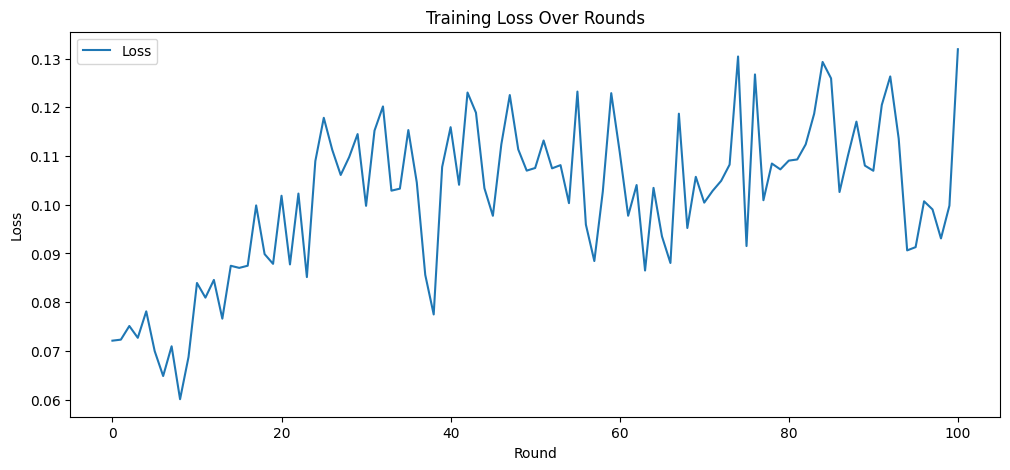

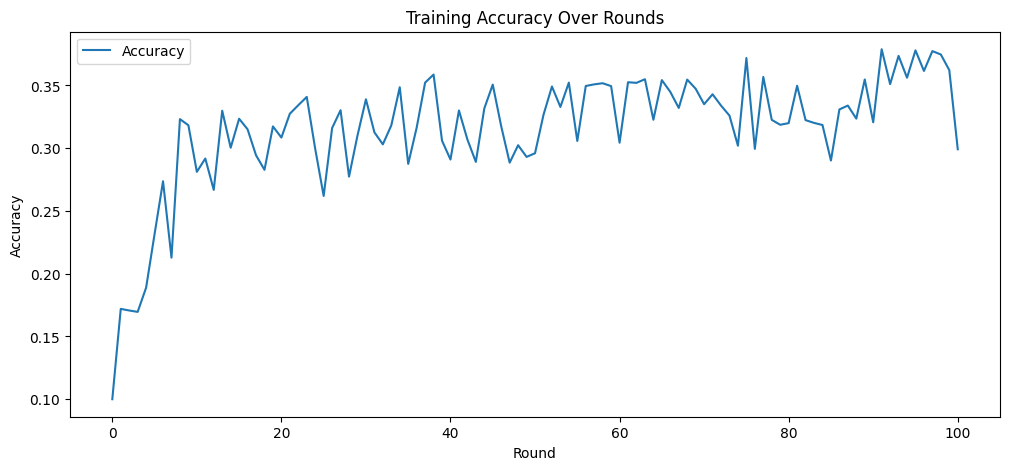

In [120]:
# Load the loss_history and accuracy_history from local storage
with open('history/fedAvg_non_iid_loss_history.pkl', 'rb') as f:
    loss_history = pickle.load(f)
    print("loss_history loaded from loss_history.pkl")
    print("Loss History : " ,loss_history)

with open('history/fedAvg_non_iid_accuracy_history.pkl', 'rb') as f:
    accuracy_history = pickle.load(f)
    print("accuracy_history loaded from accuracy_history.pkl")
    print("Accuracy History : " ,accuracy_history)

# Plot the results
# Plot loss
plt.figure(figsize=(12, 5))
plt.plot(loss_history, label='Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Training Loss Over Rounds')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.plot(accuracy_history, label='Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Rounds')
plt.legend()
plt.show()
